# DDQN-Based Autonomous Cyber Defense with Multi-Red Agent Training

This notebook implements a **Double Deep Q-Network (DQN)** agent with **Graph Neural Networks (GNNs)** for autonomous cyber defense in the CybORG++ Mini CAGE environment.

In [ ]:

import subprocess
import sys
import os
from pathlib import Path

print("Installing dependencies...")

def install_package(package):
    """Install a package, return True if successful"""
    try:
        result = subprocess.run(
            [sys.executable, "-m", "pip", "install", "-q", package],
            capture_output=True, text=True
        )
        return result.returncode == 0
    except:
        return False

# Install packages one by one
packages = ["prettytable", "networkx", "paramiko", "seaborn", "pandas", "matplotlib"]
for pkg in packages:
    if install_package(pkg):
        print(f"  {pkg}")
    else:
        print(f"  {pkg} (may already be installed)")

# Try gym - use gymnasium as fallback if gym fails
if not install_package("gym==0.21.0"):
    print("  gym==0.21.0 failed, trying without version constraint...")
    if not install_package("gym"):
        print("  gym failed, trying gymnasium...")
        install_package("gymnasium")

print("Dependencies setup complete")

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

print(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}")

# Set base path based on environment
if IN_COLAB:
    BASE_PATH = Path("/content")
else:
    # Local: Use the notebook's directory
    BASE_PATH = Path("/Users/anjaneyabhardwaj/Desktop/CSE-556-Project")

CYBORG_REPO = BASE_PATH / "CybORG_plus_plus"

# Clone if needed (skip if exists)
if not CYBORG_REPO.exists():
    print("Cloning CybORG++...")
    subprocess.run(["git", "clone", 
                    "https://github.com/alan-turing-institute/CybORG_plus_plus",
                    str(CYBORG_REPO)], check=True)
else:
    print(f"CybORG++ already exists at {CYBORG_REPO}")

CYBORG_MODULE_PATH = CYBORG_REPO / "Debugged_CybORG" / "CybORG"
print(f"Adding to sys.path: {CYBORG_MODULE_PATH}")
sys.path.insert(0, str(CYBORG_MODULE_PATH))

# Import CybORG
import inspect
from CybORG import CybORG
from CybORG.Agents import B_lineAgent, SleepAgent, RedMeanderAgent
from CybORG.Agents.Wrappers import ChallengeWrapper

RED_AGENTS = {
    'B_line': B_lineAgent,
    'Meander': RedMeanderAgent
}
print(f"Available Red agents: {list(RED_AGENTS.keys())}")

cyborg_file = Path(inspect.getfile(CybORG))
scenario_path = cyborg_file.parent / "Shared" / "Scenarios" / "Scenario1b.yaml"

if not scenario_path.exists():
    raise FileNotFoundError(f"Scenario not found at: {scenario_path}")

print(f"Scenario path: {scenario_path}")

# Create environment
cyborg = CybORG(str(scenario_path), 'sim', agents={'Red': B_lineAgent})
env = ChallengeWrapper(env=cyborg, agent_name='Blue')


obs, info = env.reset()
print("CybORG++ is now working")
print(f"Observation shape: {obs.shape}")
print(f"Action space size: {env.action_space.n}")

# Run a quick test episode
done = False
total_reward = 0
step = 0
while not done and step < 20:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    step += 1

print(f"\nTest episode: {step} steps, reward: {total_reward:.2f}")

Installing dependencies...
  prettytable
  prettytable
  networkx
  networkx
  paramiko
  paramiko
  seaborn
  seaborn
  pandas
  pandas
  matplotlib
  matplotlib
  gym==0.21.0 failed, trying without version constraint...
  gym==0.21.0 failed, trying without version constraint...
Dependencies setup complete
Environment: Local
CybORG++ already exists at /Users/anjaneyabhardwaj/Desktop/CSE-556-Project/CybORG_plus_plus
Adding to sys.path: /Users/anjaneyabhardwaj/Desktop/CSE-556-Project/CybORG_plus_plus/Debugged_CybORG/CybORG
Available Red agents: ['B_line', 'Meander']
Scenario path: /Users/anjaneyabhardwaj/Desktop/CSE-556-Project/CybORG_plus_plus/Debugged_CybORG/CybORG/CybORG/Shared/Scenarios/Scenario1b.yaml
CybORG++ is now working!
Observation shape: (52,)
Action space size: 54

Test episode: 20 steps, reward: -41.80
Dependencies setup complete
Environment: Local
CybORG++ already exists at /Users/anjaneyabhardwaj/Desktop/CSE-556-Project/CybORG_plus_plus
Adding to sys.path: /Users/anjaney

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import deque, namedtuple
from dataclasses import dataclass
import inspect
from pathlib import Path

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

@dataclass
class DQNConfig:
    """DQN Hyperparameters"""
    seed: int = 42
    
    
    max_episode_steps: int = 50
    num_episodes: int = 6000
    
    
    gamma: float = 0.99              # Discount factor
    lr: float = 1e-4                 # Learning rate
    batch_size: int = 64             # Batch size for training
    buffer_size: int = 100000        # Replay buffer size
    
    
    epsilon_start: float = 1.0       # Initial exploration rate
    epsilon_end: float = 0.05        # Final exploration rate
    epsilon_decay: float = 0.9995    # Decay rate per episode
    
    
    target_update_freq: int = 100    # Steps between target network updates
    tau: float = 0.005               # Soft update coefficient
    
    
    hidden_dim: int = 256
    gnn_hidden_dim: int = 64
    gnn_out_dim: int = 32
    
    
    train_freq: int = 4              # Steps between training updates
    grad_clip: float = 1.0           # Gradient clipping

cfg = DQNConfig()

random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if device.type == "cuda":
    torch.cuda.manual_seed_all(cfg.seed)

print("\nDQN Configuration:")
for field, value in cfg.__dict__.items():
    print(f"   {field}: {value}")


Using device: cpu

DQN Configuration:
   seed: 42
   max_episode_steps: 50
   num_episodes: 6000
   gamma: 0.99
   lr: 0.0001
   batch_size: 64
   buffer_size: 100000
   epsilon_start: 1.0
   epsilon_end: 0.05
   epsilon_decay: 0.9995
   target_update_freq: 100
   tau: 0.005
   hidden_dim: 256
   gnn_hidden_dim: 64
   gnn_out_dim: 32
   train_freq: 4
   grad_clip: 1.0


In [ ]:


class MultiRedMiniCage:
    
    def __init__(self, agent_name='Blue', max_steps=50, red_agents=None):
        self.path = str(scenario_path)
        self.agent_name = agent_name
        self.max_steps = max_steps
        self.num_hosts = 13
        self.feat_dim = 6
        self.obs_dim = self.num_hosts * self.feat_dim  # 78
        
        # Available Red agents
        if red_agents is None:
            self.red_agents = {
                'B_line': B_lineAgent,
                'Meander': RedMeanderAgent
            }
        else:
            self.red_agents = red_agents
        
        self.red_agent_names = list(self.red_agents.keys())
        self.current_red = None
        self.red_episode_counts = {name: 0 for name in self.red_agent_names}
        
        # Initialize with first Red agent to get action space
        self._create_env(self.red_agent_names[0])
        self.action_space = self.env.action_space
        
    def _create_env(self, red_name):
        """Create environment with specified Red agent"""
        red_agent_class = self.red_agents[red_name]
        self.cyborg = CybORG(self.path, 'sim', agents={'Red': red_agent_class})
        self.env = ChallengeWrapper(env=self.cyborg, agent_name=self.agent_name)
        self.current_red = red_name
        
    def reset(self):
        """Reset with a randomly selected Red agent"""
        self.step_count = 0
        
        # Randomly select Red agent
        selected_red = random.choice(self.red_agent_names)
        self._create_env(selected_red)
        self.red_episode_counts[selected_red] += 1
        
        obs, info = self.env.reset()
        info['red_agent'] = self.current_red  # Track which Red is active
        return self._process_obs(obs), self._get_info(info)
        
    def step(self, action):
        self.step_count += 1
        obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated or (self.step_count >= self.max_steps)
        info['red_agent'] = self.current_red
        return self._process_obs(obs), reward, done, False, self._get_info(info)
        
    def _process_obs(self, obs):
        """Convert CybORG 52-dim obs to 78-dim (13 nodes * 6 features)"""
        new_obs = np.zeros(78, dtype=np.float32)
        
        if len(obs) == 52:
            obs_reshaped = obs.reshape(13, 4)
            expanded_obs = np.zeros((13, 6), dtype=np.float32)
            expanded_obs[:, :4] = obs_reshaped
            
            # Add derived features
            for i in range(13):
                expanded_obs[i, 4] = obs_reshaped[i, :].sum() / 4.0  # Mean of features
                expanded_obs[i, 5] = i / 13.0  # Normalized node index
                
            new_obs = expanded_obs.flatten()
        else:
            new_obs[:min(len(obs), 78)] = obs[:min(len(obs), 78)]
            
        return new_obs

    def _get_info(self, info):
        if 'action_mask' not in info:
            info['action_mask'] = np.ones(self.action_space.n, dtype=np.int32)
        return info
    
    def get_red_stats(self):
        
        total = sum(self.red_episode_counts.values())
        stats = {name: f"{count} ({100*count/max(total,1):.1f}%)" 
                 for name, count in self.red_episode_counts.items()}
        return stats

print("MULTI-RED AGENT ENVIRONMENT")

env = MultiRedMiniCage(max_steps=cfg.max_episode_steps)

#  Red selection
print("\nTesting random Red agent selection (10 resets):")
for i in range(10):
    obs, info = env.reset()
    print(f"{i+1}: Red = {info['red_agent']}")

print(f"\nRed agent distribution: {env.get_red_stats()}")
print(f"Observation dimension: {len(obs)}")
print(f"Action space: {env.action_space.n} actions")


MULTI-RED AGENT ENVIRONMENT

Testing random Red agent selection (10 resets):
1: Red = Meander
2: Red = Meander
3: Red = B_line
4: Red = Meander
5: Red = B_line
2: Red = Meander
3: Red = B_line
4: Red = Meander
5: Red = B_line
6: Red = B_line
7: Red = Meander
8: Red = Meander
9: Red = B_line
6: Red = B_line
7: Red = Meander
8: Red = Meander
9: Red = B_line
10: Red = B_line

Red agent distribution: {'B_line': '5 (50.0%)', 'Meander': '5 (50.0%)'}
Observation dimension: 78
Action space: 54 actions
10: Red = B_line

Red agent distribution: {'B_line': '5 (50.0%)', 'Meander': '5 (50.0%)'}
Observation dimension: 78
Action space: 54 actions


/var/folders/pm/2n62h2gn3jjgqdzwnjtg8scm0000gn/T/ipykernel_25548/3903129310.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


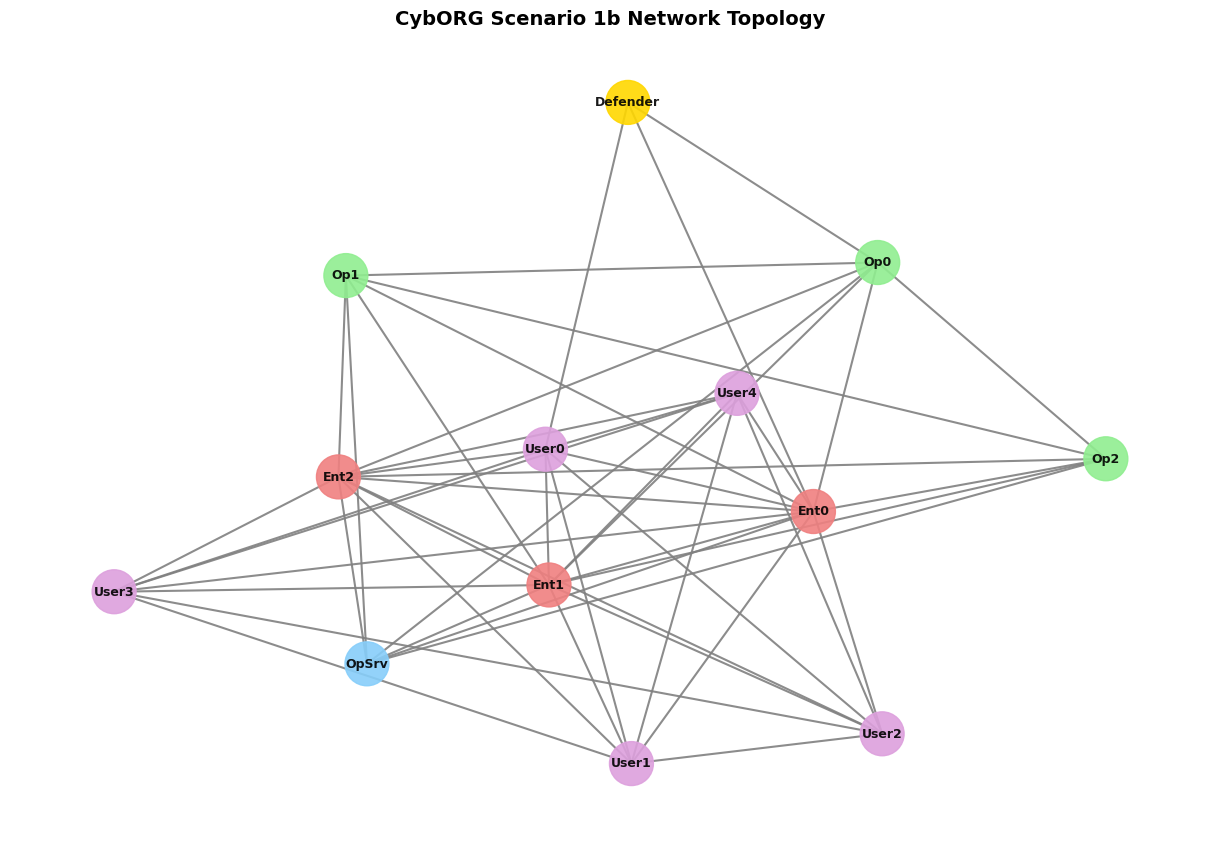


Adjacency matrix shape: torch.Size([13, 13])
Number of edges: 49


In [ ]:

import networkx as nx

def get_static_adjacency_matrix(device):
    
    num_nodes = 13
    A = torch.zeros((num_nodes, num_nodes), device=device)
    
    # Define subnets
    subnet_user = [8, 9, 10, 11, 12]  # User workstations
    subnet_ent = [1, 2, 3]             # Enterprise servers
    subnet_op = [4, 5, 6]              # Operational hosts
    op_server = [7]                    # Operational server
    gateway = 0                        # Defender/Gateway
    
    # Fully connect hosts within each subnet
    for subnet in [subnet_user, subnet_ent, subnet_op]:
        for i in subnet:
            for j in subnet:
                if i != j:
                    A[i, j] = 1.0
                    A[j, i] = 1.0
    
    # Connect Gateway to subnet representatives
    for rep in [subnet_user[0], subnet_ent[0], subnet_op[0]]:
        A[gateway, rep] = 1.0
        A[rep, gateway] = 1.0
        
    # Inter-Subnet Connections (Attack Paths)
    # User <-> Enterprise
    for u in subnet_user:
        for e in subnet_ent:
            A[u, e] = 1.0
            A[e, u] = 1.0
            
    # Enterprise <-> Op_Server
    for e in subnet_ent:
        for o in op_server:
            A[e, o] = 1.0
            A[o, e] = 1.0
            
    # Enterprise <-> Op_Host
    for e in subnet_ent:
        for o in subnet_op:
            A[e, o] = 1.0
            A[o, e] = 1.0
            
    # Op_Server <-> Op_Host
    for s in op_server:
        for o in subnet_op:
            A[s, o] = 1.0
            A[o, s] = 1.0

    # Add self-loops
    A = A + torch.eye(num_nodes, device=device)
    
    # normalization
    degree = A.sum(dim=1)
    d_inv_sqrt = torch.pow(degree, -0.5)
    d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = torch.diag(d_inv_sqrt)
    A_norm = torch.mm(torch.mm(D_inv_sqrt, A), D_inv_sqrt)
    
    return A_norm

# Visualize the topology
A_static = get_static_adjacency_matrix(device)
A_np = A_static.cpu().numpy()

# Create graph for visualization (remove self-loops and denormalize for display)
A_display = (A_np > 0.01).astype(float)
np.fill_diagonal(A_display, 0)

G = nx.from_numpy_array(A_display)
host_names = ['Defender', 'Ent0', 'Ent1', 'Ent2', 'Op0', 'Op1', 'Op2', 'OpSrv', 'User0', 'User1', 'User2', 'User3', 'User4']

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=2)

# Color nodes by subnet
colors = ['gold'] + ['lightcoral']*3 + ['lightgreen']*3 + ['lightskyblue'] + ['plum']*5

nx.draw(G, pos,
        node_color=colors,
        node_size=1000,
        with_labels=True,
        labels={i: host_names[i] for i in range(len(host_names))},
        font_size=9,
        font_weight='bold',
        edge_color='gray',
        width=1.5,
        alpha=0.9)

plt.title("CybORG Scenario 1b Network Topology", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nAdjacency matrix shape: {A_static.shape}")
print(f"Number of edges: {int((A_display.sum()) / 2)}")


In [ ]:

class GraphSAGEEncoder(nn.Module):
    
    def __init__(self, obs_dim=78, num_nodes=13, embed_dim=32, 
                 hidden_dim=64, out_dim=32, dropout=0.1):
        super().__init__()
        self.num_nodes = num_nodes
        self.embed_dim = embed_dim
        
        # Learnable projection: flat observation -> node embeddings
        self.input_proj = nn.Sequential(
            nn.Linear(obs_dim, num_nodes * embed_dim),
            nn.ReLU(),
            nn.LayerNorm(num_nodes * embed_dim)
        )
        
        # GraphSAGE Layer 1
        self.lin_self_1 = nn.Linear(embed_dim, hidden_dim)
        self.lin_neigh_1 = nn.Linear(embed_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        
        # GraphSAGE Layer 2
        self.lin_self_2 = nn.Linear(hidden_dim, out_dim)
        self.lin_neigh_2 = nn.Linear(hidden_dim, out_dim)
        self.ln2 = nn.LayerNorm(out_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, obs_flat, A):
        
        batch_size = obs_flat.size(0)
        
        # Project flat obs to node embeddings
        x = self.input_proj(obs_flat)
        x = x.view(batch_size, self.num_nodes, self.embed_dim)
        
        # Expand adjacency for batch processing
        A_batch = A.unsqueeze(0).expand(batch_size, -1, -1)
        
        # Layer 1: Aggregate + Transform
        agg1 = torch.bmm(A_batch, x)  # Neighbor aggregation
        h1 = self.lin_self_1(x) + self.lin_neigh_1(agg1)
        h1 = self.ln1(h1)
        h1 = F.relu(h1)
        h1 = self.dropout(h1)
        
        # Layer 2: Aggregate + Transform
        agg2 = torch.bmm(A_batch, h1)
        h2 = self.lin_self_2(h1) + self.lin_neigh_2(agg2)
        h2 = self.ln2(h2)
        h2 = F.relu(h2)
        
        return h2

# Test GNN encoder
gnn_encoder = GraphSAGEEncoder(
    obs_dim=78,
    num_nodes=13,
    embed_dim=32,
    hidden_dim=cfg.gnn_hidden_dim,
    out_dim=cfg.gnn_out_dim
).to(device)

# Test forward pass
test_obs = torch.FloatTensor(obs).unsqueeze(0).to(device)
test_embeddings = gnn_encoder(test_obs, A_static)

print("GraphSAGE Encoder Ready")
print(f"Input: {test_obs.shape}")
print(f"Output: {test_embeddings.shape}")
print(f"Parameters: {sum(p.numel() for p in gnn_encoder.parameters()):,}")


GraphSAGE Encoder Ready
Input: torch.Size([1, 78])
Output: torch.Size([1, 13, 32])
Parameters: 42,272


In [ ]:


class DQNNetwork(nn.Module):
    
    def __init__(self, obs_dim=78, action_dim=54, hidden_dim=256,
                 gnn_hidden=64, gnn_out=32, num_nodes=13):
        super().__init__()
        self.num_nodes = num_nodes
        self.gnn_out = gnn_out
        
        # GNN Encoder
        self.gnn = GraphSAGEEncoder(
            obs_dim=obs_dim,
            num_nodes=num_nodes,
            embed_dim=32,
            hidden_dim=gnn_hidden,
            out_dim=gnn_out
        )
        
        flat_dim = num_nodes * gnn_out  # 13 * 32 = 416
        
        # Shared feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(flat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Dueling DQN: Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Dueling DQN: Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim)
        )
        
    def forward(self, obs, A, action_mask=None):
        
        batch_size = obs.size(0)
        
        node_emb = self.gnn(obs, A)  # [batch, 13, 32]
        flat = node_emb.view(batch_size, -1)  # [batch, 416]
        
        features = self.feature_layer(flat)
        
        value = self.value_stream(features)  # [batch, 1]
        advantage = self.advantage_stream(features)  # [batch, action_dim]
        
        # Q = V + (A - mean(A))
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        # Apply action mask (set invalid actions to very low Q-values)
        if action_mask is not None:
            if action_mask.device != q_values.device:
                action_mask = action_mask.to(q_values.device)
            q_values = q_values.masked_fill(action_mask == 0, -1e9)
        
        return q_values

# Test Q-Network
q_network = DQNNetwork(
    obs_dim=78,
    action_dim=env.action_space.n,
    hidden_dim=cfg.hidden_dim,
    gnn_hidden=cfg.gnn_hidden_dim,
    gnn_out=cfg.gnn_out_dim
).to(device)

# Test forward pass
test_q = q_network(test_obs, A_static)

print("DQN Q-Network Ready")
print(f"Input observation: {test_obs.shape}")
print(f"Output Q-values: {test_q.shape}")
print(f"Total parameters: {sum(p.numel() for p in q_network.parameters()):,}")


DQN Q-Network Ready
Input observation: torch.Size([1, 78])
Output Q-values: torch.Size([1, 54])
Total parameters: 287,703


In [ ]:

class PrioritizedReplayBuffer:
    
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.alpha = alpha  # Priority exponent
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1
        
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.pos = 0
        
    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        
        max_priority = self.priorities.max() if self.buffer else 1.0
        
        transition = (state, action, reward, next_state, done, action_mask, next_action_mask)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
            
        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity
        
    def sample(self, batch_size):
        
        n = len(self.buffer)
        
        if n < batch_size:
            batch_size = n
        
        priorities = self.priorities[:n]
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        indices = np.random.choice(n, batch_size, p=probs, replace=False)
        
        beta = min(1.0, self.beta_start + self.frame * (1.0 - self.beta_start) / self.beta_frames)
        self.frame += 1
        
        weights = (n * probs[indices]) ** (-beta)
        weights /= weights.max()  # Normalize
        
        # Get batch
        batch = [self.buffer[idx] for idx in indices]
        
        states = torch.FloatTensor(np.array([t[0] for t in batch]))
        actions = torch.LongTensor([t[1] for t in batch])
        rewards = torch.FloatTensor([t[2] for t in batch])
        next_states = torch.FloatTensor(np.array([t[3] for t in batch]))
        dones = torch.FloatTensor([t[4] for t in batch])
        action_masks = torch.FloatTensor(np.array([t[5] for t in batch]))
        next_action_masks = torch.FloatTensor(np.array([t[6] for t in batch]))
        weights = torch.FloatTensor(weights)
        
        return (states, actions, rewards, next_states, dones, 
                action_masks, next_action_masks, weights, indices)
    
    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error) + 1e-6  # Small constant to avoid zero priority
            
    def __len__(self):
        return len(self.buffer)

# Simple Replay Buffer (fallback)
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        self.buffer.append((state, action, reward, next_state, done, action_mask, next_action_mask))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        
        states = torch.FloatTensor(np.array([t[0] for t in batch]))
        actions = torch.LongTensor([t[1] for t in batch])
        rewards = torch.FloatTensor([t[2] for t in batch])
        next_states = torch.FloatTensor(np.array([t[3] for t in batch]))
        dones = torch.FloatTensor([t[4] for t in batch])
        action_masks = torch.FloatTensor(np.array([t[5] for t in batch]))
        next_action_masks = torch.FloatTensor(np.array([t[6] for t in batch]))
        
        return states, actions, rewards, next_states, dones, action_masks, next_action_masks
    
    def __len__(self):
        return len(self.buffer)

print("Replay Buffers Ready")
print("PrioritizedReplayBuffer: TD-error based sampling")
print("ReplayBuffer: Uniform random sampling")


Replay Buffers Ready
PrioritizedReplayBuffer: TD-error based sampling
ReplayBuffer: Uniform random sampling


In [ ]:
# Cell 7: DQN Agent

class DQNAgent:
    
    def __init__(self, obs_dim, action_dim, adjacency_matrix, config):
        self.action_dim = action_dim
        self.A = adjacency_matrix
        self.cfg = config
        self.epsilon = config.epsilon_start
        self.total_steps = 0
        
        # Q-Networks
        self.q_network = DQNNetwork(
            obs_dim=obs_dim,
            action_dim=action_dim,
            hidden_dim=config.hidden_dim,
            gnn_hidden=config.gnn_hidden_dim,
            gnn_out=config.gnn_out_dim
        ).to(device)
        
        self.target_network = DQNNetwork(
            obs_dim=obs_dim,
            action_dim=action_dim,
            hidden_dim=config.hidden_dim,
            gnn_hidden=config.gnn_hidden_dim,
            gnn_out=config.gnn_out_dim
        ).to(device)
        
        # Copy weights to target
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=config.lr)
        
        # Replay Buffer
        self.replay_buffer = PrioritizedReplayBuffer(
            capacity=config.buffer_size,
            alpha=0.6,
            beta_start=0.4
        )
        
        # Metrics
        self.losses = []
        
    def select_action(self, state, action_mask=None, deterministic=False):
    
        if not deterministic and random.random() < self.epsilon:
            if action_mask is not None:
                valid_actions = np.where(action_mask == 1)[0]
                return np.random.choice(valid_actions)
            else:
                return random.randrange(self.action_dim)
        else:
            # Greedy action
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                mask_t = torch.FloatTensor(action_mask).unsqueeze(0).to(device) if action_mask is not None else None
                q_values = self.q_network(state_t, self.A, mask_t)
                return q_values.argmax(dim=1).item()
    
    def store_transition(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        
        self.replay_buffer.push(state, action, reward, next_state, done, action_mask, next_action_mask)
        
    def train_step(self):
        if len(self.replay_buffer) < self.cfg.batch_size:
            return None
        
        # Sample batch
        batch = self.replay_buffer.sample(self.cfg.batch_size)
        states, actions, rewards, next_states, dones, action_masks, next_action_masks, weights, indices = batch
        
        # Move to device
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        next_states = next_states.to(device)
        dones = dones.to(device)
        action_masks = action_masks.to(device)
        next_action_masks = next_action_masks.to(device)
        weights = weights.to(device)
        
        # Current Q values
        current_q = self.q_network(states, self.A, action_masks)
        current_q = current_q.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        with torch.no_grad():
            next_q_online = self.q_network(next_states, self.A, next_action_masks)
            next_actions = next_q_online.argmax(dim=1)
            
            # Evaluate with target network
            next_q_target = self.target_network(next_states, self.A, next_action_masks)
            next_q = next_q_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
            
            # Compute target
            target_q = rewards + self.cfg.gamma * next_q * (1 - dones)
        
        # TD Error for priority update
        td_errors = (current_q - target_q).detach().cpu().numpy()
        
        # Weighted loss
        loss = (weights * F.smooth_l1_loss(current_q, target_q, reduction='none')).mean()
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), self.cfg.grad_clip)
        self.optimizer.step()
        
        # Update priorities
        self.replay_buffer.update_priorities(indices, td_errors)
        
        self.losses.append(loss.item())
        return loss.item()
    
    def soft_update_target(self):
        for target_param, online_param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.cfg.tau * online_param.data + (1.0 - self.cfg.tau) * target_param.data)
            
    def decay_epsilon(self):
        self.epsilon = max(self.cfg.epsilon_end, self.epsilon * self.cfg.epsilon_decay)
        
    def save(self, path):
        """Save model checkpoint"""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'total_steps': self.total_steps
        }, path)
        
    def load(self, path):
        """Load model checkpoint"""
        checkpoint = torch.load(path, map_location=device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.total_steps = checkpoint['total_steps']

# Initialize agent
agent = DQNAgent(
    obs_dim=78,
    action_dim=env.action_space.n,
    adjacency_matrix=A_static,
    config=cfg
)

print("DQN Agent Ready")
print(f"Q-Network parameters: {sum(p.numel() for p in agent.q_network.parameters()):,}")
print(f"Initial epsilon: {agent.epsilon}")
print(f"Replay buffer capacity: {cfg.buffer_size:,}")


DQN Agent Ready
Q-Network parameters: 287,703
Initial epsilon: 1.0
Replay buffer capacity: 100,000


In [ ]:
# Cell 8: Reward Shaper

class RewardShaper:
    def __init__(self, spam_penalty=-2.0, clip_range=(-100, 10)):
        self.spam_penalty = spam_penalty
        self.clip_range = clip_range
        self.action_history = deque(maxlen=5)
        
    def reset(self):
        self.action_history.clear()
        
    def shape(self, reward, action, done):
        """Shape the reward signal."""
        shaped_reward = reward
        
        # Spam penalty for repetitive actions
        if action in self.action_history:
            shaped_reward += self.spam_penalty
        self.action_history.append(action)
        
        # Clip rewards (keeps training stable)
        shaped_reward = np.clip(shaped_reward, self.clip_range[0], self.clip_range[1])
        
        return shaped_reward

reward_shaper = RewardShaper()
print("Reward Shaper Ready")


Reward Shaper Ready


In [ ]:


print("STARTING DQN TRAINING (Multiple-Red Agent against one blue)")

print(f"Episodes: {cfg.num_episodes}")
print(f"Max steps per episode: {cfg.max_episode_steps}")
print(f"Red Agents: {list(env.red_agents.keys())}")
print(f"Device: {device}")


# Tracking - Overall
episode_rewards = []
episode_lengths = []
epsilon_history = []
best_avg_reward = float('-inf')

# Tracking - Per Red Agent
red_rewards = {name: [] for name in env.red_agent_names}
red_episode_indices = {name: [] for name in env.red_agent_names}

# Training
for episode in range(cfg.num_episodes):
    obs, info = env.reset()
    current_red = info.get('red_agent', 'Unknown')
    reward_shaper.reset()
    action_mask = info.get('action_mask', np.ones(env.action_space.n))
    
    episode_reward = 0
    episode_length = 0
    
    for step in range(cfg.max_episode_steps):
        # Select action
        action = agent.select_action(obs, action_mask)
        
        # Take step
        next_obs, reward, done, truncated, info = env.step(action)
        next_action_mask = info.get('action_mask', np.ones(env.action_space.n))
        
        # Shape reward
        shaped_reward = reward_shaper.shape(reward, action, done)
        
        # Store transition
        agent.store_transition(obs, action, shaped_reward, next_obs, done, action_mask, next_action_mask)
        
        # Train
        agent.total_steps += 1
        if agent.total_steps % cfg.train_freq == 0:
            agent.train_step()
            
        # Soft update target network
        if agent.total_steps % cfg.target_update_freq == 0:
            agent.soft_update_target()
        
        episode_reward += reward  # Track original reward
        episode_length += 1
        
        obs = next_obs
        action_mask = next_action_mask
        
        if done:
            break
    
    # End of episode
    agent.decay_epsilon()
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
    epsilon_history.append(agent.epsilon)
    
    # Track per-Red-agent performance
    red_rewards[current_red].append(episode_reward)
    red_episode_indices[current_red].append(episode)
    
    # Logging
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        avg_length = np.mean(episode_lengths[-100:])
        avg_loss = np.mean(agent.losses[-1000:]) if agent.losses else 0
        
        # Per-Red averages
        red_avgs = {}
        for name in env.red_agent_names:
            if len(red_rewards[name]) >= 10:
                red_avgs[name] = np.mean(red_rewards[name][-50:])
            else:
                red_avgs[name] = 0.0
        
        print(f"Episode {episode + 1:5d} | "
              f"Avg Reward: {avg_reward:8.2f} | "
              f"Epsilon: {agent.epsilon:.4f} | "
              f"Loss: {avg_loss:.4f}")
        print(f"             | "
              f"vs B_line: {red_avgs.get('B_line', 0):7.2f} | "
              f"vs Meander: {red_avgs.get('Meander', 0):7.2f} | "
              f"Buffer: {len(agent.replay_buffer)}")
        
        # Save best model
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            agent.save('dqn_multi_red_best.pth')
            print(f" New best model saved (Reward: {best_avg_reward:.2f})")


print("\nDQN Training Complete!")
print("\nRed Agent Training Distribution:")
print(f"   {env.get_red_stats()}")
print("\nFinal Performance by Red Agent:")
for name in env.red_agent_names:
    if red_rewards[name]:
        avg = np.mean(red_rewards[name][-100:])
        print(f"   vs {name}: {avg:.2f} (last 100 episodes)")
agent.save('dqn_multi_red_final.pth')
print("\nFinal model saved to 'dqn_multi_red_final.pth'")


STARTING DQN TRAINING (Multiple-Red Agent against one blue)
Episodes: 6000
Max steps per episode: 50
Red Agents: ['B_line', 'Meander']
Device: cpu
Episode   100 | Avg Reward:  -210.99 | Epsilon: 0.9512 | Loss: 0.5908
             | vs B_line: -276.37 | vs Meander: -137.62 | Buffer: 5000
 New best model saved (Reward: -210.99)
Episode   100 | Avg Reward:  -210.99 | Epsilon: 0.9512 | Loss: 0.5908
             | vs B_line: -276.37 | vs Meander: -137.62 | Buffer: 5000
 New best model saved (Reward: -210.99)
Episode   200 | Avg Reward:  -168.83 | Epsilon: 0.9048 | Loss: 0.6369
             | vs B_line: -180.36 | vs Meander: -146.07 | Buffer: 10000
 New best model saved (Reward: -168.83)
Episode   200 | Avg Reward:  -168.83 | Epsilon: 0.9048 | Loss: 0.6369
             | vs B_line: -180.36 | vs Meander: -146.07 | Buffer: 10000
 New best model saved (Reward: -168.83)
Episode   300 | Avg Reward:  -150.96 | Epsilon: 0.8607 | Loss: 0.6459
             | vs B_line: -165.67 | vs Meander: -134.77 |

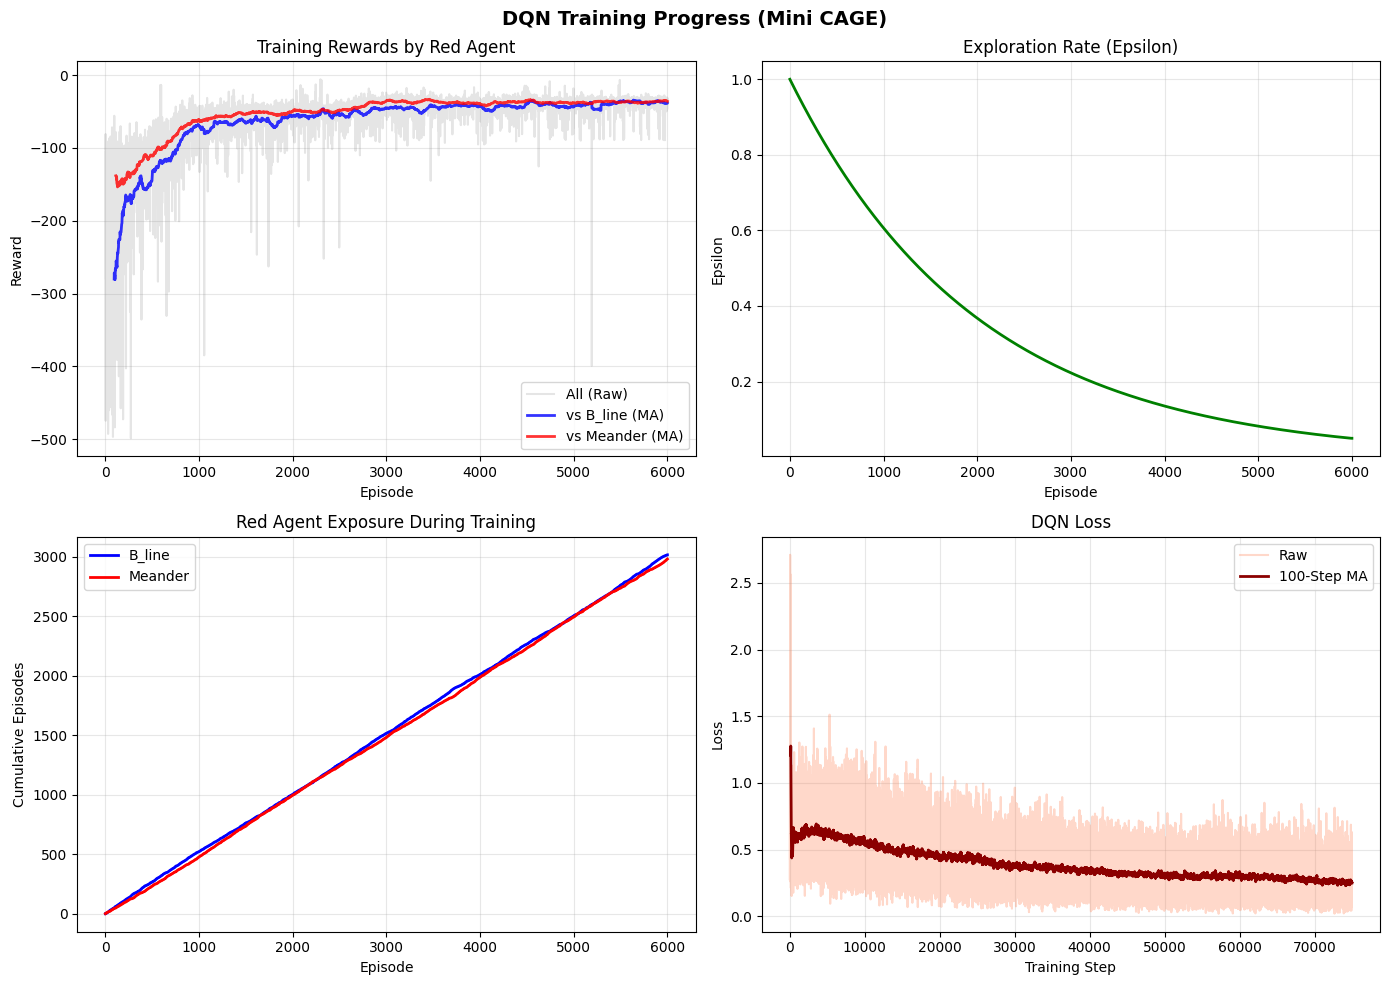

In [ ]:
# Cell 10: Training Visualization (Multi-Red Agent)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Episode Rewards (Overall + Per Red Agent)
ax1 = axes[0, 0]
ax1.plot(episode_rewards, alpha=0.2, color='gray', label='All (Raw)')
window = 50

# Plot per-Red-agent rewards
colors = {'B_line': 'blue', 'Meander': 'red'}
for name in env.red_agent_names:
    if red_rewards[name] and len(red_rewards[name]) >= window:
        indices = red_episode_indices[name]
        rewards = red_rewards[name]
        # Create moving average for this Red agent
        ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax1.plot(indices[window-1:], ma, color=colors.get(name, 'green'), 
                 linewidth=2, alpha=0.8, label=f'vs {name} (MA)')
                 
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.set_title('Training Rewards by Red Agent')
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2 = axes[0, 1]
ax2.plot(epsilon_history, color='green', linewidth=2)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Epsilon')
ax2.set_title('Exploration Rate (Epsilon)')
ax2.grid(True, alpha=0.3)


ax3 = axes[1, 0]
bline_cumsum = np.cumsum([1 if i in red_episode_indices['B_line'] else 0 for i in range(len(episode_rewards))])
meander_cumsum = np.cumsum([1 if i in red_episode_indices['Meander'] else 0 for i in range(len(episode_rewards))])
ax3.plot(bline_cumsum, color='blue', linewidth=2, label='B_line')
ax3.plot(meander_cumsum, color='red', linewidth=2, label='Meander')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Cumulative Episodes')
ax3.set_title('Red Agent Exposure During Training')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
if agent.losses:
    ax4.plot(agent.losses, alpha=0.3, color='coral', label='Raw')
    loss_window = 100
    if len(agent.losses) >= loss_window:
        loss_ma = np.convolve(agent.losses, np.ones(loss_window)/loss_window, mode='valid')
        ax4.plot(range(loss_window-1, len(agent.losses)), loss_ma, color='darkred', linewidth=2, label=f'{loss_window}-Step MA')
    ax4.set_xlabel('Training Step')
    ax4.set_ylabel('Loss')
    ax4.set_title('DQN Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.suptitle('DQN Training Progress (Mini CAGE)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


EVALUATION: Testing Blue vs Each Red Agent
Loaded best multi-red model

Evaluating vs B_line...


/var/folders/pm/2n62h2gn3jjgqdzwnjtg8scm0000gn/T/ipykernel_25548/99085606.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=de

   Mean: -32.12 ± 2.45

Evaluating vs Meander...
   Mean: -35.96 ± 6.33
EVALUATION SUMMARY

 vs B_line:
   Average Reward: -32.12 ± 2.45
   Min: -43.80 | Max: -30.00

 vs Meander:
   Average Reward: -35.96 ± 6.33
   Min: -68.90 | Max: -27.90

 Overall Average: -34.04 ± 5.17
   Mean: -35.96 ± 6.33
EVALUATION SUMMARY

 vs B_line:
   Average Reward: -32.12 ± 2.45
   Min: -43.80 | Max: -30.00

 vs Meander:
   Average Reward: -35.96 ± 6.33
   Min: -68.90 | Max: -27.90

 Overall Average: -34.04 ± 5.17


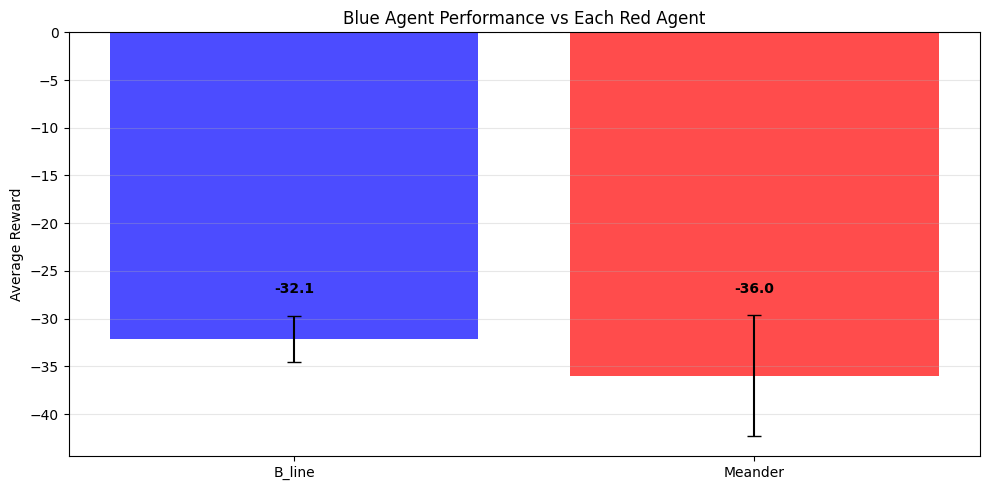

In [ ]:

print("EVALUATION: Testing Blue vs Each Red Agent")

# Load best model

agent.load('dqn_multi_red_best.pth')
print("Loaded best multi-red model")


# Evaluate against EACH Red agent separately
NUM_EVAL_EPISODES = 50

eval_results = {}

agent.q_network.eval()
with torch.no_grad():
    for red_name, red_class in RED_AGENTS.items():
        print(f"\nEvaluating vs {red_name}...")
        
        # Create environment with specific Red agent
        eval_cyborg = CybORG(str(scenario_path), 'sim', agents={'Red': red_class})
        eval_env = ChallengeWrapper(env=eval_cyborg, agent_name='Blue')
        
        red_eval_rewards = []
        red_eval_lengths = []
        
        for ep in range(NUM_EVAL_EPISODES):
            obs, info = eval_env.reset()
            # Process obs to 78-dim
            obs = env._process_obs(obs)
            action_mask = info.get('action_mask', np.ones(eval_env.action_space.n))
            
            ep_reward = 0
            ep_length = 0
            done = False
            
            while not done and ep_length < cfg.max_episode_steps:
                action = agent.select_action(obs, action_mask, deterministic=True)
                next_obs, reward, terminated, truncated, info = eval_env.step(action)
                obs = env._process_obs(next_obs)
                action_mask = info.get('action_mask', np.ones(eval_env.action_space.n))
                done = terminated or truncated
                ep_reward += reward
                ep_length += 1
                
            red_eval_rewards.append(ep_reward)
            red_eval_lengths.append(ep_length)
        
        eval_results[red_name] = {
            'rewards': red_eval_rewards,
            'mean': np.mean(red_eval_rewards),
            'std': np.std(red_eval_rewards),
            'min': np.min(red_eval_rewards),
            'max': np.max(red_eval_rewards)
        }
        
        print(f"   Mean: {eval_results[red_name]['mean']:.2f} ± {eval_results[red_name]['std']:.2f}")

agent.q_network.train()

print("EVALUATION SUMMARY")

for red_name, results in eval_results.items():
    print(f"\n vs {red_name}:")
    print(f"   Average Reward: {results['mean']:.2f} ± {results['std']:.2f}")
    print(f"   Min: {results['min']:.2f} | Max: {results['max']:.2f}")


all_rewards = []
for results in eval_results.values():
    all_rewards.extend(results['rewards'])
print(f"\n Overall Average: {np.mean(all_rewards):.2f} ± {np.std(all_rewards):.2f}")

fig, ax = plt.subplots(figsize=(10, 5))
positions = range(len(eval_results))
names = list(eval_results.keys())
means = [eval_results[n]['mean'] for n in names]
stds = [eval_results[n]['std'] for n in names]

bars = ax.bar(positions, means, yerr=stds, capsize=5, color=['blue', 'red'], alpha=0.7)
ax.set_xticks(positions)
ax.set_xticklabels(names)
ax.set_ylabel('Average Reward')
ax.set_title('Blue Agent Performance vs Each Red Agent')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')

for i, (bar, mean) in enumerate(zip(bars, means)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + stds[i] + 2, 
            f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


BEHAVIORAL ANALYSIS


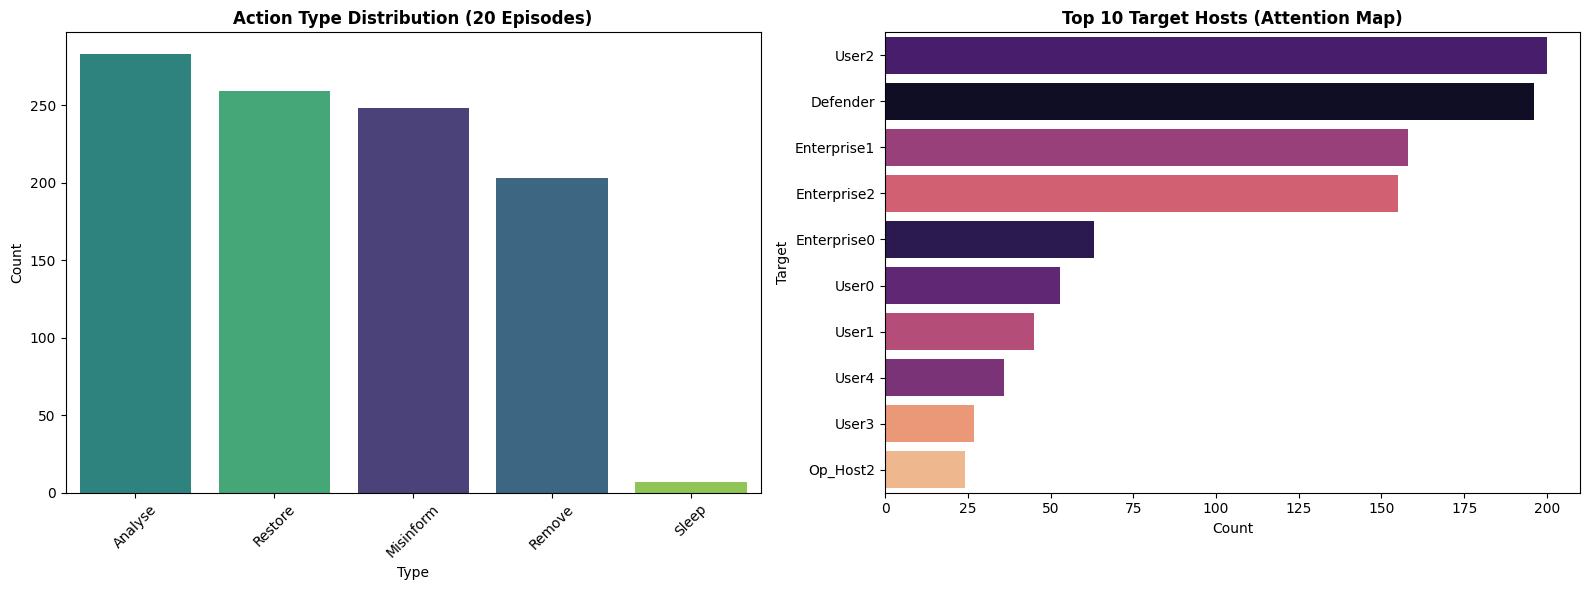


BEHAVIORAL INSIGHTS:
1. Total actions analyzed: 1000
2. Dominant Strategy: 'Analyse'
3. Primary Target: 'User2'

Action Type Breakdown:
   - Analyse: 283 (28.3%)
   - Restore: 259 (25.9%)
   - Misinform: 248 (24.8%)
   - Remove: 203 (20.3%)
   - Sleep: 7 (0.7%)

Recovered 24 Action Labels dynamically.
   Sample: ['Misinform Defender', 'Remove Enterprise0', 'Remove User2', 'Misinform User0', 'Misinform User4']


In [ ]:
# Cell 12: Behavioral Analysis

print("BEHAVIORAL ANALYSIS")

NUM_ANALYSIS_EPISODES = 20
history = []
action_map = {}

agent.q_network.eval()
with torch.no_grad():
    for ep in range(NUM_ANALYSIS_EPISODES):
        obs, info = env.reset()
        action_mask = info.get('action_mask', np.ones(env.action_space.n))
        done = False
        step = 0
        
        while not done:
            action_idx = agent.select_action(obs, action_mask, deterministic=True)
            obs, reward, done, truncated, info = env.step(action_idx)
            action_mask = info.get('action_mask', np.ones(env.action_space.n))
            
            
            action_str = f"Action {action_idx}"
            if hasattr(env, 'cyborg'):
                last_action = env.cyborg.get_last_action('Blue')
                if last_action is not None:
                    action_str = str(last_action)
                    action_map[action_idx] = action_str
            
            
            if action_idx in action_map:
                action_str = action_map[action_idx]
            
            parts = str(action_str).split(' ')
            act_type = parts[0]
            target = parts[1] if len(parts) > 1 else "None"
            
            history.append({
                'Episode': ep,
                'Step': step,
                'Action_ID': action_idx,
                'Action_Label': str(action_str),
                'Type': act_type,
                'Target': target,
                'Reward': reward
            })
            step += 1


df = pd.DataFrame(history)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

if not df.empty:
    sns.countplot(data=df, x='Type', ax=axes[0], hue='Type', 
                  palette='viridis', order=df['Type'].value_counts().index, legend=False)
    axes[0].set_title(f"Action Type Distribution ({NUM_ANALYSIS_EPISODES} Episodes)", fontweight='bold')
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis='x', rotation=45)


    df_targets = df[df['Target'] != 'None']
    if not df_targets.empty:
        sns.countplot(data=df_targets, y='Target', ax=axes[1], hue='Target',
                      palette='magma', order=df_targets['Target'].value_counts().index[:10], legend=False)
        axes[1].set_title("Top 10 Target Hosts (Attention Map)", fontweight='bold')
        axes[1].set_xlabel("Count")

plt.tight_layout()
plt.show()

# Insights
print("\nBEHAVIORAL INSIGHTS:")
if not df.empty:
    print(f"1. Total actions analyzed: {len(df)}")
    
    top_action = df['Type'].mode()[0]
    print(f"2. Dominant Strategy: '{top_action}'")
    
    if not df_targets.empty:
        top_target = df_targets['Target'].mode()[0]
        print(f"3. Primary Target: '{top_target}'")
    
    # Action breakdown
    print("\nAction Type Breakdown:")
    for act_type, count in df['Type'].value_counts().head(5).items():
        pct = 100 * count / len(df)
        print(f"   - {act_type}: {count} ({pct:.1f}%)")
    
    print(f"\nRecovered {len(action_map)} Action Labels dynamically.")
    if action_map:
        print(f"   Sample: {list(action_map.values())[:5]}")


Q-VALUE ANALYSIS


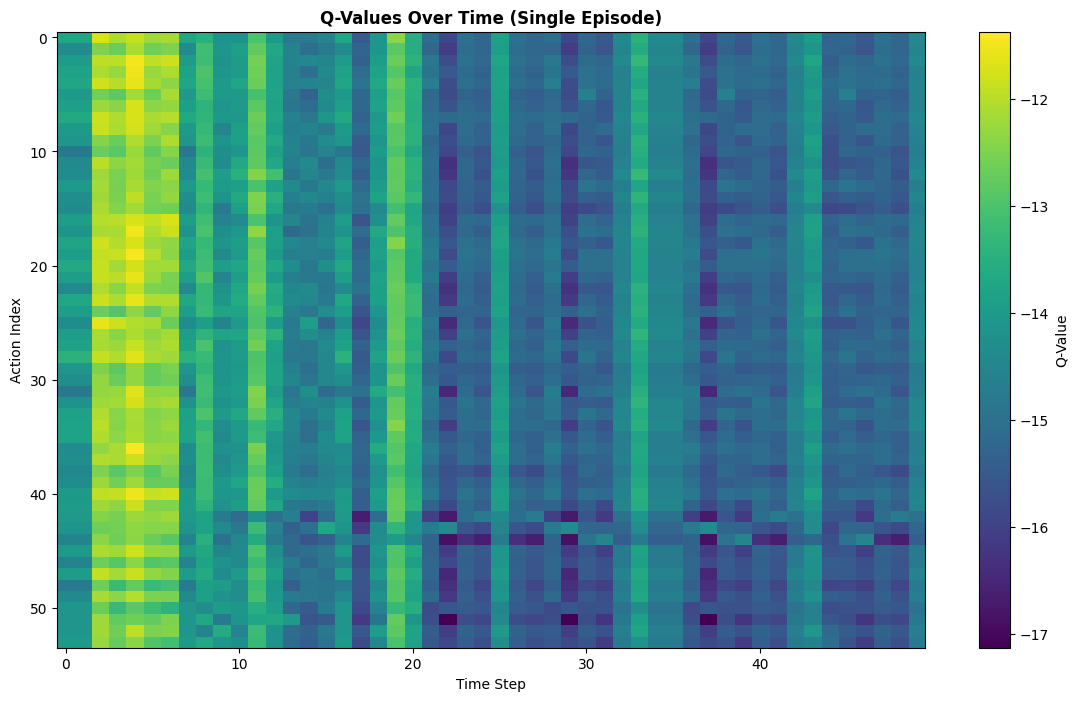


Q-Value Statistics:
   Max Q-value: -11.3723
   Min Q-value (excluding masked): -17.1305
   Mean Q-value (excluding masked): -14.4778


In [ ]:

print("Q-VALUE ANALYSIS")

q_values_list = []

agent.q_network.eval()
with torch.no_grad():
    obs, info = env.reset()
    action_mask = info.get('action_mask', np.ones(env.action_space.n))
    
    for step in range(cfg.max_episode_steps):
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
        mask_t = torch.FloatTensor(action_mask).unsqueeze(0).to(device)
        
        q_values = agent.q_network(obs_t, A_static, mask_t)
        q_values_list.append(q_values.squeeze().cpu().numpy())
        
        action = q_values.argmax(dim=1).item()
        obs, reward, done, truncated, info = env.step(action)
        action_mask = info.get('action_mask', np.ones(env.action_space.n))
        
        if done:
            break

q_values_array = np.array(q_values_list)

# Plot Q-value heatmap
plt.figure(figsize=(14, 8))
plt.imshow(q_values_array.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Q-Value')
plt.xlabel('Time Step')
plt.ylabel('Action Index')
plt.title('Q-Values Over Time (Single Episode)', fontweight='bold')
plt.show()


print(f"\nQ-Value Statistics:")
print(f"   Max Q-value: {q_values_array.max():.4f}")
print(f"   Min Q-value (excluding masked): {q_values_array[q_values_array > -1e8].min():.4f}")
print(f"   Mean Q-value (excluding masked): {q_values_array[q_values_array > -1e8].mean():.4f}")


#PHASE 2: Red Agent Training with DDQN (Curriculum Learning)

Now we train a **Red (attacker) agent** using **DDQN** .

## Training Pipeline

Phase 1  : Blue DQN trained vs B_lineAgent + RedMeanderAgent
Phase 2  :  Red DQN trained with CURRICULUM LEARNING
   └─ Phase 2a: Train vs SleepAgent (learn attack chain)
   └─ Phase 2b: Train vs Trained Blue DQN (generalize against intelligent defense)
Phase 3 (Next): Self-play evaluation




## Features
- **Full 56-action space** from ChallengeWrapper
- **78-dim observation** (13 hosts × 6 features, same as checkpoint)
- **RAW CybORG rewards** (no shaping)
- **Double DQN** with action masking
- **Proper curriculum learning** with trained Blue opponent

## Red Agent Actions (CybORG - 56 total)
- **Sleep** - Do nothing
- **DiscoverRemoteSystems** - Scan subnet for hosts
- **DiscoverNetworkServices** - Scan host for services
- **ExploitRemoteService** - Exploit vulnerable service
- **PrivilegeEscalate** - Escalate to root/admin
- **Impact** - Disrupt operations (goal)


In [ ]:

from CybORG.Agents.Wrappers import ChallengeWrapper
import time


@dataclass
class RedDQNConfig:
    # Training
    num_episodes: int = 12000
    max_steps: int = 50
    
    # Curriculum Learning
    curriculum_phase1_episodes: int = 3000  # Phase 1: Train vs SleepAgent
    
    # DQN Parameters
    gamma: float = 0.99
    lr: float = 3e-4
    batch_size: int = 64
    buffer_size: int = 100000
    
    # Exploration
    epsilon_start: float = 1.0
    epsilon_end: float = 0.05
    epsilon_decay: float = 0.9997  # Slower decay for more exploration
    
    # Target Network
    target_update_freq: int = 100
    tau: float = 0.005
    
    # Network
    hidden_dim: int = 256
    
    # Training
    train_freq: int = 4
    grad_clip: float = 0.5

red_cfg = RedDQNConfig()



temp_cyborg = CybORG(str(scenario_path), 'sim', agents={'Blue': SleepAgent})
temp_env = ChallengeWrapper(env=temp_cyborg, agent_name='Red')

red_action_idx_to_label = {}
red_action_idx_to_type = {}


try:
    from CybORG.Agents.Wrappers import EnumActionWrapper
    
    temp_cyborg2 = CybORG(str(scenario_path), 'sim', agents={'Blue': SleepAgent})
    temp_enum = EnumActionWrapper(temp_cyborg2, agent='Red')
    temp_enum.reset()
    
    if hasattr(temp_enum, 'action_labels') and temp_enum.action_labels:
        action_labels = temp_enum.action_labels.get('Red', [])
        print(f"Found {len(action_labels)} action labels from EnumActionWrapper")
        
        for action_idx, label in enumerate(action_labels):
            label_str = str(label)
            red_action_idx_to_label[action_idx] = label_str
            action_type = label_str.split()[0].split('(')[0] if label_str else 'Unknown'
            red_action_idx_to_type[action_idx] = action_type
    else:
        raise Exception("No action_labels found")
        
    del temp_cyborg2, temp_enum
    
except Exception as e:
    print(f"Could not get action labels directly: {e}")
    print("   Falling back to execution-based mapping...")
    
    for action_idx in range(56):
        try:
            temp_env.reset()
            temp_env.step(action_idx)
            last_action = temp_cyborg.get_last_action('Red')
            if last_action is not None:
                action_str = str(last_action)
                red_action_idx_to_label[action_idx] = action_str
                action_type = action_str.split()[0] if action_str else 'Unknown'
                
                if action_type == 'InvalidAction':
                    # CybORG Scenario1b action ranges:
                    # 0: Sleep
                    # 1-13: DiscoverRemoteSystems variants
                    # 14-26: DiscoverNetworkServices variants  
                    # 27-39: ExploitRemoteService variants
                    # 40-52: PrivilegeEscalate variants
                    # 53-55: Impact variants
                    if action_idx == 0:
                        action_type = 'Sleep'
                    elif 1 <= action_idx <= 13:
                        action_type = 'DiscoverRemoteSystems'
                    elif 14 <= action_idx <= 26:
                        action_type = 'DiscoverNetworkServices'
                    elif 27 <= action_idx <= 39:
                        action_type = 'ExploitRemoteService'
                    elif 40 <= action_idx <= 52:
                        action_type = 'PrivilegeEscalate'
                    elif 53 <= action_idx <= 55:
                        action_type = 'Impact'
                    else:
                        action_type = 'Unknown'
                
                red_action_idx_to_type[action_idx] = action_type
            else:
                red_action_idx_to_label[action_idx] = f"Action_{action_idx}"
                red_action_idx_to_type[action_idx] = 'Unknown'
        except Exception as ex:
            red_action_idx_to_label[action_idx] = f"Action_{action_idx}"
            red_action_idx_to_type[action_idx] = 'Unknown'

del temp_cyborg, temp_env

def get_action_type_name(action_idx):
    """Map action index to action type using CybORG's actual mapping"""
    return red_action_idx_to_type.get(action_idx, 'Unknown')

action_type_counts = {}
for idx, atype in red_action_idx_to_type.items():
    action_type_counts[atype] = action_type_counts.get(atype, 0) + 1

print(f"\nRED ACTION SPACE MAPPING (from CybORG):")
print("-" * 60)
action_types_found = set(red_action_idx_to_type.values())
for act_type in sorted(action_types_found):
    indices = [i for i, t in red_action_idx_to_type.items() if t == act_type]
    if indices:
        print(f"  {act_type}: actions {min(indices)}-{max(indices)} ({len(indices)} actions)")
print("-" * 60)

print(f"\nRed Action Space Summary (56 total):")
for atype, count in sorted(action_type_counts.items()):
    print(f"   {atype}: {count} actions")

action_reward_tracker = {}
for action_type in action_types_found:
    action_reward_tracker[action_type] = {'count': 0, 'total_reward': 0}
if 'Unknown' not in action_reward_tracker:
    action_reward_tracker['Unknown'] = {'count': 0, 'total_reward': 0}

print(f"\nAction-Reward Tracker initialized for: {sorted(action_reward_tracker.keys())}")

print("Red DQN Configuration")
print(f"Total Episodes: {red_cfg.num_episodes}")
print(f"Max steps per episode: {red_cfg.max_steps}")
print(f"Phase 1 (SleepAgent): Episodes 0-{red_cfg.curriculum_phase1_episodes}")
print(f"Phase 2 (Trained Blue): Episodes {red_cfg.curriculum_phase1_episodes}+")
print(f"Learning rate: {red_cfg.lr}")
print(f"Epsilon decay: {red_cfg.epsilon_decay}")

Could not get action labels directly: Wrapper required a dictionary action space. Please check that the wrappers below the ReduceActionSpaceWrapper return the action space as a dict 
   Falling back to execution-based mapping...

RED ACTION SPACE MAPPING (from CybORG):
------------------------------------------------------------
  DiscoverNetworkServices: actions 12-26 (13 actions)
  DiscoverRemoteSystems: actions 1-13 (12 actions)
  ExploitRemoteService: actions 25-39 (13 actions)
  Impact: actions 51-55 (4 actions)
  PrivilegeEscalate: actions 38-52 (13 actions)
  Sleep: actions 0-0 (1 actions)
------------------------------------------------------------

Red Action Space Summary (56 total):
   DiscoverNetworkServices: 13 actions
   DiscoverRemoteSystems: 12 actions
   ExploitRemoteService: 13 actions
   Impact: 4 actions
   PrivilegeEscalate: 13 actions
   Sleep: 1 actions

Action-Reward Tracker initialized for: ['DiscoverNetworkServices', 'DiscoverRemoteSystems', 'ExploitRemoteServ

In [ ]:

from CybORG.Agents.SimpleAgents.BaseAgent import BaseAgent

class TrainedBlueDQNAgent(BaseAgent):
    
    _trained_agent = None
    _adjacency_matrix = None
    _action_count = 0
    
    def __init__(self):
        
        self._last_action = None
        
    @classmethod
    def set_trained_agent(cls, blue_dqn_agent, adjacency_matrix):
        
        cls._trained_agent = blue_dqn_agent
        cls._adjacency_matrix = adjacency_matrix
        cls._action_count = 0
        cls._trained_agent.q_network.eval()
        print("TrainedBlueDQNAgent: Trained model set at class level")
        
    @classmethod
    def get_action_count(cls):
        return cls._action_count
    
    @classmethod
    def reset_action_count(cls):
        cls._action_count = 0
        
    def get_action(self, observation, action_space):
        
        # If no trained agent, fall back to random/sleep
        if TrainedBlueDQNAgent._trained_agent is None:
            return 0  # Sleep action as fallback
        
        # Handle different observation formats from CybORG
        if isinstance(observation, dict):
            obs_vector = self._dict_to_vector(observation)
        elif isinstance(observation, np.ndarray):
            obs_vector = observation
        else:
            obs_vector = np.zeros(52, dtype=np.float32)
        
        # Process observation (52 -> 78 dims) - same as Blue training
        obs_processed = self._process_obs(obs_vector)
        obs_t = torch.FloatTensor(obs_processed).unsqueeze(0).to(device)
        
        with torch.no_grad():
            # Use trained Blue DQN to select action (greedy, no exploration)
            q_values = TrainedBlueDQNAgent._trained_agent.q_network(
                obs_t, 
                TrainedBlueDQNAgent._adjacency_matrix, 
                action_mask=None
            )
            action = q_values.argmax(dim=1).item()
        
        self._last_action = action
        TrainedBlueDQNAgent._action_count += 1
        return action
    
    def _dict_to_vector(self, obs_dict):
        """Convert CybORG dict observation to 52-dim vector"""
        vector = np.zeros(52, dtype=np.float32)
        
        try:
            idx = 0
            for key, value in obs_dict.items():
                if key == 'success':
                    continue
                if isinstance(value, dict):
                    for subkey, subval in value.items():
                        if isinstance(subval, (int, float)) and idx < 52:
                            vector[idx] = float(subval)
                            idx += 1
                        elif isinstance(subval, dict):
                            for v in subval.values():
                                if isinstance(v, (int, float)) and idx < 52:
                                    vector[idx] = float(v)
                                    idx += 1
        except Exception:
            pass
        
        return vector
    
    def _process_obs(self, obs):
        """Convert 52-dim CybORG obs to 78-dim (13 nodes * 6 features)"""
        new_obs = np.zeros(78, dtype=np.float32)
        
        if len(obs) >= 52:
            obs_52 = obs[:52]
            obs_reshaped = obs_52.reshape(13, 4)
            expanded_obs = np.zeros((13, 6), dtype=np.float32)
            expanded_obs[:, :4] = obs_reshaped
            for i in range(13):
                expanded_obs[i, 4] = obs_reshaped[i, :].sum() / 4.0
                expanded_obs[i, 5] = i / 13.0
            new_obs = expanded_obs.flatten()
        else:
            new_obs[:len(obs)] = obs
            
        return new_obs
    
    # Required BaseAgent interface methods
    def train(self, results):
        pass
    
    def end_episode(self):
        pass
    
    def set_initial_values(self, action_space, observation):
        pass


class MiniCageRed:
    
    def __init__(self, max_steps=50):
        
        self.path = str(scenario_path)
        self.max_steps = max_steps
        
        # Dimensions
        self.num_hosts = 13
        self.feat_dim = 6
        self.obs_dim = self.num_hosts * self.feat_dim  # 78
        
        self.use_sleep_agent = True  # Start with Phase 1
        
        self._create_env()
        self.action_space = self.env.action_space
        self.num_actions = self.action_space.n  # 56 for Red
        
        # State tracking
        self.step_count = 0
        self.attack_history = []
        
    def _create_env(self):
        """Create CybORG environment with appropriate Blue agent"""
        if self.use_sleep_agent:
            # Phase 1: Use SleepAgent (no defense)
            self.cyborg = CybORG(self.path, 'sim', agents={'Blue': SleepAgent})
        else:
            # Phase 2: 
            # CybORG will call TrainedBlueDQNAgent() to create an instance
            # That instance accesses the trained model via class variables
            self.cyborg = CybORG(self.path, 'sim', agents={'Blue': TrainedBlueDQNAgent})
        
        self.env = ChallengeWrapper(env=self.cyborg, agent_name='Red')
        
    def set_trained_blue(self, blue_dqn_agent, adjacency_matrix):
        
        TrainedBlueDQNAgent.set_trained_agent(blue_dqn_agent, adjacency_matrix)
        print("Trained Blue DQN configured for Phase 2")
        
    def reset(self):
        self.step_count = 0
        self.attack_history = []
        self._create_env()
        obs, info = self.env.reset()
        return self._process_obs(obs), self._get_info(info)
    
    def step(self, red_action):
        
        self.step_count += 1
        
        obs, reward, terminated, truncated, info = self.env.step(red_action)
        self.attack_history.append(red_action)
        done = terminated or truncated or (self.step_count >= self.max_steps)

        return self._process_obs(obs), reward, done, False, self._get_info(info)
    
    def _process_obs(self, obs):
        """Convert CybORG observation to 78-dim feature vector"""
        new_obs = np.zeros(78, dtype=np.float32)
        
        if isinstance(obs, np.ndarray) and len(obs) == 52:
            obs_reshaped = obs.reshape(13, 4)
            expanded_obs = np.zeros((13, 6), dtype=np.float32)
            expanded_obs[:, :4] = obs_reshaped
            
            for i in range(13):
                expanded_obs[i, 4] = obs_reshaped[i, :].sum() / 4.0
                expanded_obs[i, 5] = i / 13.0
                
            new_obs = expanded_obs.flatten()
        elif isinstance(obs, np.ndarray):
            new_obs[:min(len(obs), 78)] = obs[:min(len(obs), 78)]
            
        return new_obs
    
    def _get_info(self, info):
        """Get info dict with action mask"""
        action_mask = info.get('action_mask', np.ones(self.num_actions, dtype=np.int32))
        return {'action_mask': action_mask}


print("RED AGENT ENVIRONMENT (MiniCageRed) ")

print("TrainedBlueDQNAgent uses CLASS-level storage")
print("CybORG receives the CLASS, not an instance")
print("CybORG calls TrainedBlueDQNAgent() to create instances")

red_env = MiniCageRed(max_steps=red_cfg.max_steps)

print(f"\nObservation dim: {red_env.obs_dim}")
print(f"Action space: {red_env.num_actions} actions")

# Test reset (Phase 1 - SleepAgent)
obs, info = red_env.reset()
print(f"\nPhase 1 test (vs SleepAgent):")
print(f"   Observation shape: {obs.shape}")
print(f"   Action mask shape: {info['action_mask'].shape}")

# Test step
obs, reward, done, _, info = red_env.step(0)
print(f"\nStep test (action=0):")
print(f"   Reward: {reward}")
print(f"   Done: {done}")


print("Phase 1: use_sleep_agent=True  → Blue = SleepAgent")
print("Phase 2: use_sleep_agent=False → Blue = TrainedBlueDQNAgent CLASS")

RED AGENT ENVIRONMENT (MiniCageRed) 
TrainedBlueDQNAgent uses CLASS-level storage
CybORG receives the CLASS, not an instance
CybORG calls TrainedBlueDQNAgent() to create instances

Observation dim: 78
Action space: 56 actions

Phase 1 test (vs SleepAgent):
   Observation shape: (78,)
   Action mask shape: (56,)

Step test (action=0):
   Reward: 0.0
   Done: False
Phase 1: use_sleep_agent=True  → Blue = SleepAgent
Phase 2: use_sleep_agent=False → Blue = TrainedBlueDQNAgent CLASS


In [ ]:


class RedDQNNetwork(nn.Module):
    """Simple MLP network for Red agent (no GNN needed)- as we dont want our the red agents to have any information about the graph"""
    def __init__(self, obs_dim=78, action_dim=56, hidden_dim=256):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim)
        )
        
    def forward(self, obs, action_mask=None):
        q_values = self.network(obs)
        
        if action_mask is not None:
            # Mask invalid actions
            if isinstance(action_mask, np.ndarray):
                action_mask = torch.tensor(action_mask, device=obs.device, dtype=torch.float32)
            if action_mask.dim() == 1:
                action_mask = action_mask.unsqueeze(0).expand(q_values.size(0), -1)
            q_values = q_values.masked_fill(action_mask == 0, -1e9)
        
        return q_values


class RedDQNAgent:
    """Double DQN Agent for Red attacker"""
    def __init__(self, obs_dim, action_dim, config):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.cfg = config
        self.epsilon = config.epsilon_start
        self.total_steps = 0
        
        # Networks
        self.q_network = RedDQNNetwork(obs_dim, action_dim, config.hidden_dim).to(device)
        self.target_network = RedDQNNetwork(obs_dim, action_dim, config.hidden_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=config.lr)
        
        # Replay buffer (reuse from Blue agent)
        self.replay_buffer = ReplayBuffer(config.buffer_size)
        
        # Metrics
        self.losses = []
        
    def select_action(self, state, action_mask=None, deterministic=False):
        """Epsilon-greedy action selection"""
        if not deterministic and random.random() < self.epsilon:
            # Random from valid actions
            if action_mask is not None:
                valid_actions = np.where(action_mask == 1)[0]
                if len(valid_actions) > 0:
                    return np.random.choice(valid_actions)
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.q_network(state_t, action_mask)
                return q_values.argmax(dim=1).item()
    
    def store_transition(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        """Store transition in replay buffer"""
        self.replay_buffer.push(state, action, reward, next_state, done, action_mask, next_action_mask)
        
    def train_step(self):
        """One training step with Double DQN"""
        if len(self.replay_buffer) < self.cfg.batch_size:
            return None
        
        # Sample batch
        batch = self.replay_buffer.sample(self.cfg.batch_size)
        states, actions, rewards, next_states, dones, action_masks, next_action_masks = batch
        
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        next_states = next_states.to(device)
        dones = dones.to(device)
        action_masks = action_masks.to(device)
        next_action_masks = next_action_masks.to(device)
        
        # Current Q values
        current_q = self.q_network(states, action_masks)
        current_q = current_q.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Target Q values (Double DQN)
        with torch.no_grad():
            next_q_online = self.q_network(next_states, next_action_masks)
            next_actions = next_q_online.argmax(dim=1)
            next_q_target = self.target_network(next_states, next_action_masks)
            next_q = next_q_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q = rewards + self.cfg.gamma * next_q * (1 - dones)
        
        # Loss
        loss = F.smooth_l1_loss(current_q, target_q)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), self.cfg.grad_clip)
        self.optimizer.step()
        
        self.losses.append(loss.item())
        return loss.item()
    
    def soft_update_target(self):
        """Soft update target network"""
        for target_param, param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.cfg.tau * param.data + (1 - self.cfg.tau) * target_param.data)
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.cfg.epsilon_end, self.epsilon * self.cfg.epsilon_decay)
        
    def save(self, path):
        """Save checkpoint"""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'total_steps': self.total_steps
        }, path)
        
    def load(self, path):
        """Load checkpoint"""
        checkpoint = torch.load(path, map_location=device, weights_only=False)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.total_steps = checkpoint['total_steps']

print("INITIALIZING RED DQN AGENT")

red_agent = RedDQNAgent(
    obs_dim=red_env.obs_dim,
    action_dim=red_env.num_actions,
    config=red_cfg
)

print(f"Observation dim: {red_env.obs_dim}")
print(f"Action dim: {red_env.num_actions}")
print(f"Network params: {sum(p.numel() for p in red_agent.q_network.parameters()):,}")
print(f"Initial epsilon: {red_agent.epsilon}")

INITIALIZING RED DQN AGENT
Observation dim: 78
Action dim: 56
Network params: 126,136
Initial epsilon: 1.0


In [ ]:

import time
import os

print("RED DQN TRAINING WITH CURRICULUM LEARNING (SEPARATE PHASES)")
print("\n Loading trained Blue DQN agent...")

blue_model_paths = ['dqn_multi_red_best.pth', 'dqn_best_model.pth', 'dqn_final_model.pth']
blue_agent_for_phase2 = None
blue_model_loaded = None

for path in blue_model_paths:
    if os.path.exists(path):
        blue_model_loaded = path
        break

if blue_model_loaded:
    blue_agent_for_phase2 = DQNAgent(
        obs_dim=78, action_dim=54, adjacency_matrix=A_static, config=cfg
    )
    blue_agent_for_phase2.load(blue_model_loaded)
    blue_agent_for_phase2.q_network.eval()
    for param in blue_agent_for_phase2.q_network.parameters():
        param.requires_grad = False
    print(f"Loaded Blue model: {blue_model_loaded}")
else:
    print("No Blue model found - Phase 2 will use SleepAgent")

red_episode_rewards = []
red_episode_lengths = []
phase1_rewards = []
phase2_rewards = []
best_red_reward = float('-inf')
total_steps = 0
start_time = time.time()

for key in action_reward_tracker:
    action_reward_tracker[key] = {'count': 0, 'total_reward': 0}

def process_obs_78(obs):
    """Convert 52-dim obs to 78-dim"""
    new_obs = np.zeros(78, dtype=np.float32)
    if isinstance(obs, np.ndarray) and len(obs) == 52:
        obs_reshaped = obs.reshape(13, 4)
        expanded = np.zeros((13, 6), dtype=np.float32)
        expanded[:, :4] = obs_reshaped
        for i in range(13):
            expanded[i, 4] = obs_reshaped[i].sum() / 4.0
            expanded[i, 5] = i / 13.0
        new_obs = expanded.flatten()
    elif isinstance(obs, np.ndarray):
        new_obs[:min(len(obs), 78)] = obs[:min(len(obs), 78)]
    return new_obs

def get_blue_action(blue_obs_raw):
    """Get action from trained Blue DQN"""
    if blue_agent_for_phase2 is None:
        return 0  # Sleep
    
    # Convert observation
    if isinstance(blue_obs_raw, dict):
        obs_vec = np.zeros(52, dtype=np.float32)
        idx = 0
        for key, val in blue_obs_raw.items():
            if key == 'success':
                continue
            if isinstance(val, dict):
                for v in val.values():
                    if isinstance(v, (int, float)) and idx < 52:
                        obs_vec[idx] = float(v)
                        idx += 1
    else:
        obs_vec = blue_obs_raw if isinstance(blue_obs_raw, np.ndarray) else np.zeros(52)
    
    obs_78 = process_obs_78(obs_vec)
    obs_t = torch.FloatTensor(obs_78).unsqueeze(0).to(device)
    
    with torch.no_grad():
        q_vals = blue_agent_for_phase2.q_network(obs_t, A_static, None)
        return q_vals.argmax(dim=1).item()


print(" PHASE 1: Training Red vs SleepAgent (No Defense)")
print(f"Episodes: 0 to {red_cfg.curriculum_phase1_episodes}")

phase1_cyborg = CybORG(str(scenario_path), 'sim', agents={'Blue': SleepAgent})
phase1_env = ChallengeWrapper(env=phase1_cyborg, agent_name='Red')

for episode in range(red_cfg.curriculum_phase1_episodes):
    obs_raw, info = phase1_env.reset()
    obs = process_obs_78(obs_raw)
    action_mask = info.get('action_mask', np.ones(56))
    
    episode_reward = 0
    episode_length = 0
    
    for step in range(red_cfg.max_steps):
        # Select action
        action = red_agent.select_action(obs, action_mask)
        
        # Step
        next_obs_raw, reward, terminated, truncated, next_info = phase1_env.step(action)
        next_obs = process_obs_78(next_obs_raw)
        next_action_mask = next_info.get('action_mask', np.ones(56))
        done = terminated or truncated or (step + 1 >= red_cfg.max_steps)
        
        # Track
        action_type = get_action_type_name(action)
        action_reward_tracker[action_type]['count'] += 1
        action_reward_tracker[action_type]['total_reward'] += reward
        
        # Store & train
        red_agent.store_transition(obs, action, reward, next_obs, done, action_mask, next_action_mask)
        red_agent.total_steps += 1
        total_steps += 1
        
        if red_agent.total_steps % red_cfg.train_freq == 0:
            red_agent.train_step()
        if red_agent.total_steps % red_cfg.target_update_freq == 0:
            red_agent.soft_update_target()
        
        episode_reward += reward
        episode_length += 1
        obs = next_obs
        action_mask = next_action_mask
        
        if done:
            break
    
    # End episode
    red_agent.decay_epsilon()
    red_episode_rewards.append(episode_reward)
    red_episode_lengths.append(episode_length)
    phase1_rewards.append(episode_reward)
    
    # Logging
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(red_episode_rewards[-100:])
        avg_loss = np.mean(red_agent.losses[-1000:]) if red_agent.losses else 0
        elapsed = time.time() - start_time
        print(f"[P1] Episode {episode+1:5d} | Avg Reward: {avg_reward:8.2f} | "
              f"Epsilon: {red_agent.epsilon:.4f} | Loss: {avg_loss:.4f} | Time: {elapsed:.0f}s")
        
        if avg_reward > best_red_reward:
            best_red_reward = avg_reward
            red_agent.save('red_dqn_best.pth')
            print(f"  New best model! (Reward: {best_red_reward:.2f})")

# Phase 1 summary
phase1_final_avg = np.mean(phase1_rewards[-100:]) if len(phase1_rewards) >= 100 else np.mean(phase1_rewards)
print(f"\nPhase 1 Complete!")
print(f"   Final Avg Reward: {phase1_final_avg:.2f}")
print(f"   Episodes: {len(phase1_rewards)}")

del phase1_cyborg, phase1_env

#phase 2 training
print("PHASE 2: Training Red vs TRAINED BLUE DQN")
print(f"   Episodes: {red_cfg.curriculum_phase1_episodes} to {red_cfg.num_episodes}")

if blue_agent_for_phase2 is None:
    print("No trained Blue - Phase 2 will continue with SleepAgent")
    # Create same environment as Phase 1
    phase2_cyborg = CybORG(str(scenario_path), 'sim', agents={'Blue': SleepAgent})
    phase2_env = ChallengeWrapper(env=phase2_cyborg, agent_name='Red')
    blue_is_active = False
else:
    print("Blue DQN agent is ACTIVE and will defend!")
    print("Expected: Red rewards should be lower than Phase 1\n")
    # Create environment with SleepAgent, but we'll manually step Blue
    phase2_cyborg = CybORG(str(scenario_path), 'sim', agents={'Blue': SleepAgent})
    phase2_env = ChallengeWrapper(env=phase2_cyborg, agent_name='Red')
    blue_is_active = True

blue_action_count = 0
phase2_start_episode = red_cfg.curriculum_phase1_episodes

for episode in range(phase2_start_episode, red_cfg.num_episodes):
    obs_raw, info = phase2_env.reset()
    obs = process_obs_78(obs_raw)
    action_mask = info.get('action_mask', np.ones(56))
    
    episode_reward = 0
    episode_length = 0
    
    for step in range(red_cfg.max_steps):
        # Red selects action
        action = red_agent.select_action(obs, action_mask)
        
        # Red steps
        next_obs_raw, reward, terminated, truncated, next_info = phase2_env.step(action)
        
        if blue_is_active:
            try:
                # Get Blue's observation
                blue_obs = phase2_cyborg.get_observation('Blue')
                
                # Get Blue's action from trained DQN
                blue_action = get_blue_action(blue_obs)
                blue_action_count += 1
                
                # Execute Blue's action
                phase2_cyborg.step(action=blue_action, agent='Blue')
                
                # Get updated observation for Red after Blue's action
                next_obs_raw = phase2_cyborg.get_observation('Red')
                if isinstance(next_obs_raw, dict):
                    temp_vec = np.zeros(52, dtype=np.float32)
                    idx = 0
                    for key, val in next_obs_raw.items():
                        if key == 'success':
                            continue
                        if isinstance(val, (int, float)) and idx < 52:
                            temp_vec[idx] = float(val)
                            idx += 1
                        elif isinstance(val, dict):
                            for v in val.values():
                                if isinstance(v, (int, float)) and idx < 52:
                                    temp_vec[idx] = float(v)
                                    idx += 1
                    next_obs_raw = temp_vec
                    
            except Exception as e:
                if episode == phase2_start_episode and step < 3:
                    print(f"   [DEBUG] Blue step error: {e}")
        
        next_obs = process_obs_78(next_obs_raw)
        next_action_mask = next_info.get('action_mask', np.ones(56))
        done = terminated or truncated or (step + 1 >= red_cfg.max_steps)
        
        # Track
        action_type = get_action_type_name(action)
        action_reward_tracker[action_type]['count'] += 1
        action_reward_tracker[action_type]['total_reward'] += reward
        
        # Store & train
        red_agent.store_transition(obs, action, reward, next_obs, done, action_mask, next_action_mask)
        red_agent.total_steps += 1
        total_steps += 1
        
        if red_agent.total_steps % red_cfg.train_freq == 0:
            red_agent.train_step()
        if red_agent.total_steps % red_cfg.target_update_freq == 0:
            red_agent.soft_update_target()
        
        episode_reward += reward
        episode_length += 1
        obs = next_obs
        action_mask = next_action_mask
        
        if done:
            break
    
    # End episode
    red_agent.decay_epsilon()
    red_episode_rewards.append(episode_reward)
    red_episode_lengths.append(episode_length)
    phase2_rewards.append(episode_reward)
    
    # Logging
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(red_episode_rewards[-100:])
        avg_loss = np.mean(red_agent.losses[-1000:]) if red_agent.losses else 0
        elapsed = time.time() - start_time
        
        # Compare to Phase 1
        phase2_avg = np.mean(phase2_rewards[-100:]) if len(phase2_rewards) >= 100 else np.mean(phase2_rewards)
        diff = phase2_avg - phase1_final_avg
        diff_str = f"({diff:+.1f} vs P1)" if blue_is_active else ""
        
        print(f"[P2] Episode {episode+1:5d} | Avg Reward: {avg_reward:8.2f} {diff_str} | "
              f"Epsilon: {red_agent.epsilon:.4f} | Blue actions: {blue_action_count}")
        
        # Alert if rewards are higher than Phase 1 (Blue not working)
        if blue_is_active and len(phase2_rewards) >= 100:
            if phase2_avg > phase1_final_avg + 5:
                print(f" Warning: Phase 2 rewards HIGHER than Phase 1!")
            elif phase2_avg < phase1_final_avg - 5:
                print(f" good: Blue is defending (rewards lower)")
        
        if avg_reward > best_red_reward:
            best_red_reward = avg_reward
            red_agent.save('red_dqn_best.pth')
            print(f"  New best model! (Reward: {best_red_reward:.2f})")


red_agent.save('red_dqn_final.pth')

print("RED DQN TRAINING COMPLETE")
print(f"Total Episodes: {len(red_episode_rewards)}")
print(f"Total Steps: {total_steps:,}")
print(f"Best Avg Reward: {best_red_reward:.2f}")
print(f"Final Epsilon: {red_agent.epsilon:.4f}")

if phase1_rewards and phase2_rewards:
    p1_avg = np.mean(phase1_rewards[-100:]) if len(phase1_rewards) >= 100 else np.mean(phase1_rewards)
    p2_avg = np.mean(phase2_rewards[-100:]) if len(phase2_rewards) >= 100 else np.mean(phase2_rewards)
    print(f"\nPhase Comparison:")
    print(f"   Phase 1 (vs SleepAgent): {p1_avg:.2f}")
    print(f"   Phase 2 (vs Blue DQN):   {p2_avg:.2f}")
    if p2_avg < p1_avg:
        print(f" Phase 2 rewards LOWER by {p1_avg - p2_avg:.2f} - Blue is defending!")
    else:
        print(f" Phase 2 rewards HIGHER - check Blue implementation")

print(f"\nBlue Agent Activity:")
print(f"  Total actions in Phase 2: {blue_action_count}")

print("\nAction-Reward Summary:")
for atype, stats in sorted(action_reward_tracker.items()):
    if stats['count'] > 0:
        avg = stats['total_reward'] / stats['count']
        print(f"   {atype}: {stats['count']:,} times, avg reward: {avg:.4f}")

RED DQN TRAINING WITH CURRICULUM LEARNING (SEPARATE PHASES)

 Loading trained Blue DQN agent...
Loaded Blue model: dqn_multi_red_best.pth
 PHASE 1: Training Red vs SleepAgent (No Defense)
Episodes: 0 to 3000


/var/folders/pm/2n62h2gn3jjgqdzwnjtg8scm0000gn/T/ipykernel_25548/99085606.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=de

[P1] Episode   100 | Avg Reward:    -3.40 | Epsilon: 0.9704 | Loss: 0.0017 | Time: 8s
  New best model! (Reward: -3.40)
[P1] Episode   200 | Avg Reward:    -3.60 | Epsilon: 0.9418 | Loss: 0.0007 | Time: 17s
[P1] Episode   300 | Avg Reward:    -1.89 | Epsilon: 0.9139 | Loss: 0.0002 | Time: 27s
  New best model! (Reward: -1.89)
[P1] Episode   400 | Avg Reward:    -1.53 | Epsilon: 0.8869 | Loss: 0.0004 | Time: 36s
  New best model! (Reward: -1.53)
[P1] Episode   500 | Avg Reward:    -1.91 | Epsilon: 0.8607 | Loss: 0.0004 | Time: 46s
[P1] Episode   600 | Avg Reward:    -1.73 | Epsilon: 0.8352 | Loss: 0.0004 | Time: 56s
[P1] Episode   700 | Avg Reward:     0.45 | Epsilon: 0.8106 | Loss: 0.0006 | Time: 67s
  New best model! (Reward: 0.45)
[P1] Episode   800 | Avg Reward:    10.59 | Epsilon: 0.7866 | Loss: 0.0014 | Time: 77s
  New best model! (Reward: 10.59)
[P1] Episode   900 | Avg Reward:    12.66 | Epsilon: 0.7633 | Loss: 0.0024 | Time: 89s
  New best model! (Reward: 12.66)
[P1] Episode  1

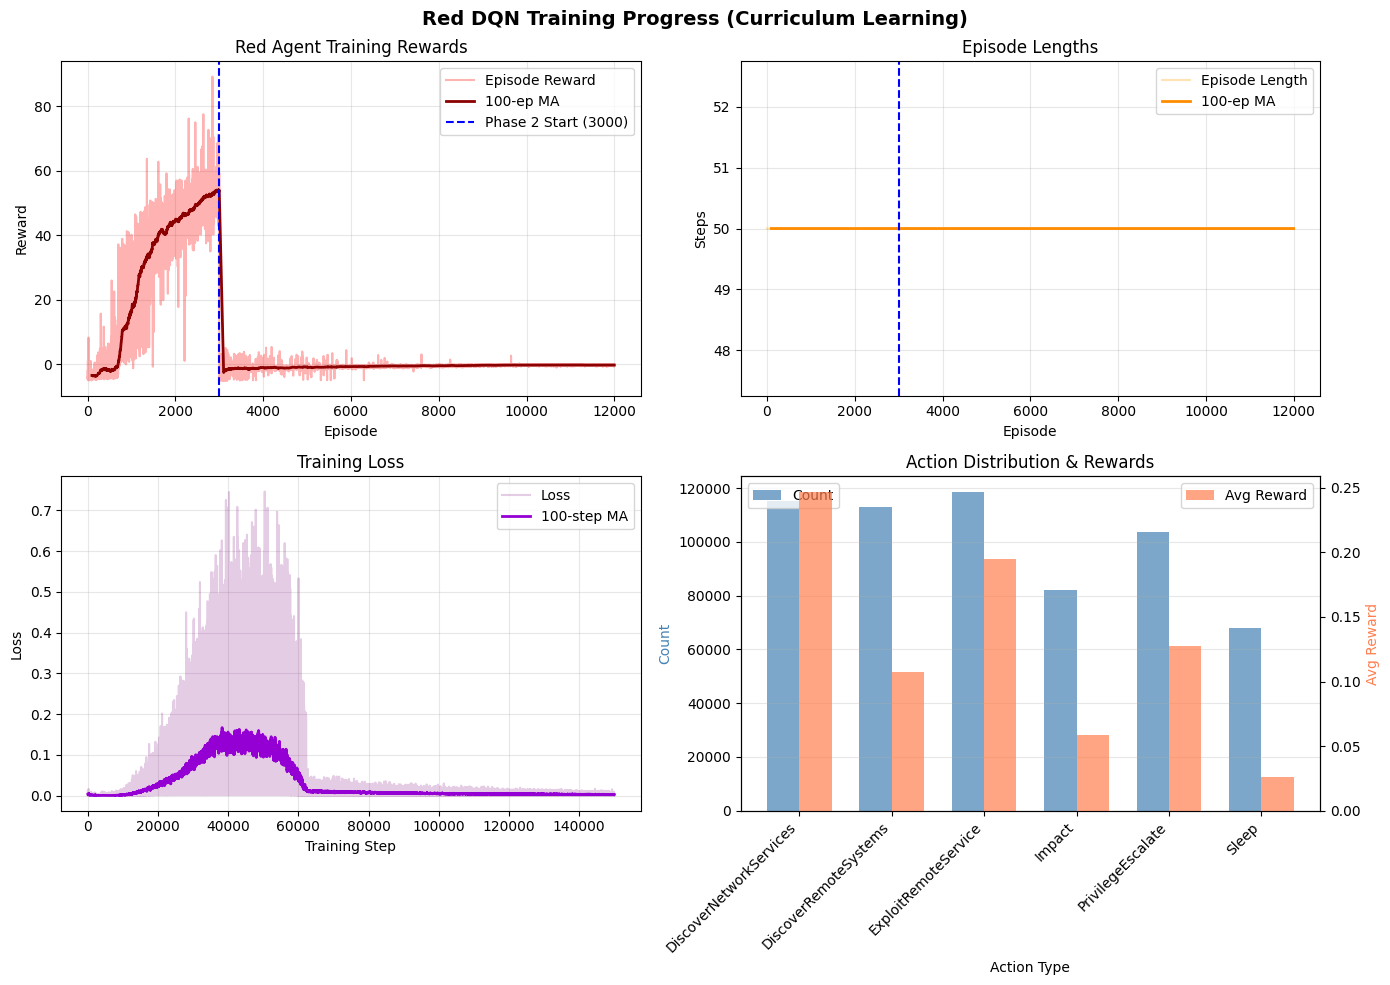

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Episode Rewards
ax1 = axes[0, 0]
ax1.plot(red_episode_rewards, alpha=0.3, color='red', label='Episode Reward')
if len(red_episode_rewards) >= 100:
    reward_ma = np.convolve(red_episode_rewards, np.ones(100)/100, mode='valid')
    ax1.plot(range(99, len(red_episode_rewards)), reward_ma, 
             color='darkred', linewidth=2, label='100-ep MA')
ax1.axvline(x=red_cfg.curriculum_phase1_episodes, color='blue', linestyle='--', 
            label=f'Phase 2 Start ({red_cfg.curriculum_phase1_episodes})')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.set_title('Red Agent Training Rewards')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Episode Lengths
ax2 = axes[0, 1]
ax2.plot(red_episode_lengths, alpha=0.3, color='orange', label='Episode Length')
if len(red_episode_lengths) >= 100:
    length_ma = np.convolve(red_episode_lengths, np.ones(100)/100, mode='valid')
    ax2.plot(range(99, len(red_episode_lengths)), length_ma, 
             color='darkorange', linewidth=2, label='100-ep MA')
ax2.axvline(x=red_cfg.curriculum_phase1_episodes, color='blue', linestyle='--')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Steps')
ax2.set_title('Episode Lengths')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Training Loss
ax3 = axes[1, 0]
if red_agent.losses:
    ax3.plot(red_agent.losses, alpha=0.2, color='purple', label='Loss')
    if len(red_agent.losses) >= 100:
        loss_ma = np.convolve(red_agent.losses, np.ones(100)/100, mode='valid')
        ax3.plot(range(99, len(red_agent.losses)), loss_ma, 
                 color='darkviolet', linewidth=2, label='100-step MA')
ax3.set_xlabel('Training Step')
ax3.set_ylabel('Loss')
ax3.set_title('Training Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Action Distribution
ax4 = axes[1, 1]
action_types = []
action_counts = []
action_avg_rewards = []
for atype, stats in sorted(action_reward_tracker.items()):
    if stats['count'] > 0:
        action_types.append(atype)
        action_counts.append(stats['count'])
        action_avg_rewards.append(stats['total_reward'] / stats['count'])

x = np.arange(len(action_types))
width = 0.35

bars1 = ax4.bar(x - width/2, action_counts, width, label='Count', color='steelblue', alpha=0.7)
ax4_twin = ax4.twinx()
bars2 = ax4_twin.bar(x + width/2, action_avg_rewards, width, label='Avg Reward', color='coral', alpha=0.7)

ax4.set_xlabel('Action Type')
ax4.set_ylabel('Count', color='steelblue')
ax4_twin.set_ylabel('Avg Reward', color='coral')
ax4.set_title('Action Distribution & Rewards')
ax4.set_xticks(x)
ax4.set_xticklabels(action_types, rotation=45, ha='right')
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Red DQN Training Progress (Curriculum Learning)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

RED AGENT EVALUATION
Loaded best Red model
  Evaluation episode 10/50
  Evaluation episode 20/50
  Evaluation episode 30/50
  Evaluation episode 40/50
  Evaluation episode 50/50
EVALUATION RESULTS
Mean Reward: 57.86 ± 0.95
Min Reward: 54.10
Max Reward: 58.10
Mean Episode Length: 50.0

Action Distribution During Evaluation:
   DiscoverNetworkServices: 2202 (88.1%)
   DiscoverRemoteSystems: 150 (6.0%)
   ExploitRemoteService: 148 (5.9%)


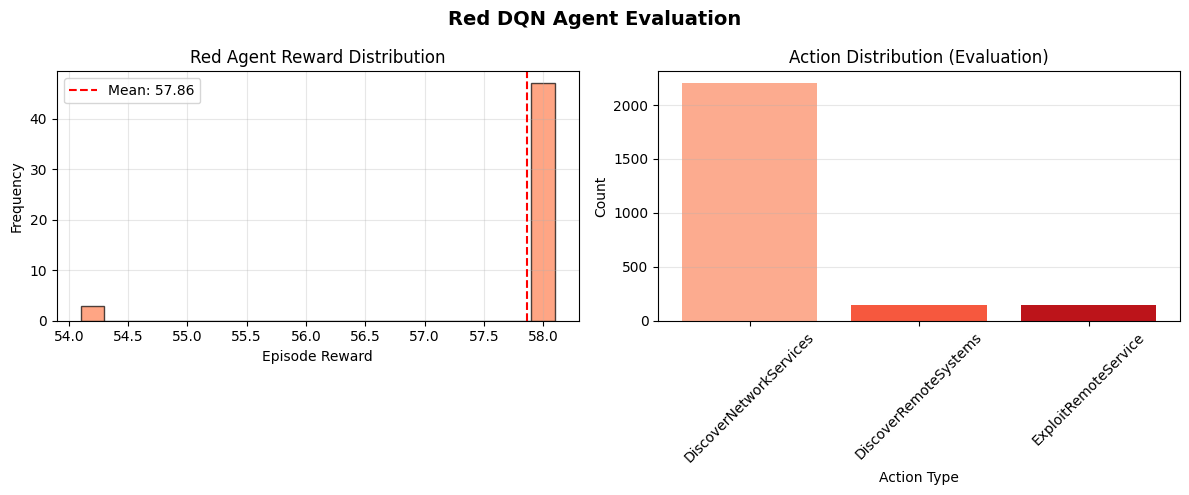

Evaluation Complete!


In [ ]:

print("RED AGENT EVALUATION")
# Load best model
try:
    red_agent.load('red_dqn_best.pth')
    print("Loaded best Red model")
except:
    print("Using current Red model")

NUM_EVAL_EPISODES = 50

red_agent.q_network.eval()
eval_rewards = []
eval_lengths = []
eval_action_counts = {k: 0 for k in action_reward_tracker.keys()}

with torch.no_grad():
    for ep in range(NUM_EVAL_EPISODES):
        obs, info = red_env.reset()
        action_mask = info.get('action_mask', np.ones(red_env.num_actions))
        
        ep_reward = 0
        ep_length = 0
        done = False
        
        while not done and ep_length < red_cfg.max_steps:
            action = red_agent.select_action(obs, action_mask, deterministic=True)
            obs, reward, done, _, info = red_env.step(action)
            action_mask = info.get('action_mask', np.ones(red_env.num_actions))
            
            action_type = get_action_type_name(action)
            eval_action_counts[action_type] += 1
            
            ep_reward += reward
            ep_length += 1
        
        eval_rewards.append(ep_reward)
        eval_lengths.append(ep_length)
        
        if (ep + 1) % 10 == 0:
            print(f"  Evaluation episode {ep + 1}/{NUM_EVAL_EPISODES}")

red_agent.q_network.train()

print("EVALUATION RESULTS")

print(f"Mean Reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
print(f"Min Reward: {np.min(eval_rewards):.2f}")
print(f"Max Reward: {np.max(eval_rewards):.2f}")
print(f"Mean Episode Length: {np.mean(eval_lengths):.1f}")

print("\nAction Distribution During Evaluation:")
total_actions = sum(eval_action_counts.values())
for atype, count in sorted(eval_action_counts.items()):
    if count > 0:
        pct = count / total_actions * 100
        print(f"   {atype}: {count} ({pct:.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Reward distribution
ax1 = axes[0]
ax1.hist(eval_rewards, bins=20, color='coral', alpha=0.7, edgecolor='black')
ax1.axvline(np.mean(eval_rewards), color='red', linestyle='--', 
            label=f'Mean: {np.mean(eval_rewards):.2f}')
ax1.set_xlabel('Episode Reward')
ax1.set_ylabel('Frequency')
ax1.set_title('Red Agent Reward Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Action distribution
ax2 = axes[1]
action_types = [k for k, v in sorted(eval_action_counts.items()) if v > 0]
counts = [eval_action_counts[k] for k in action_types]
colors = plt.cm.Reds(np.linspace(0.3, 0.8, len(action_types)))
ax2.bar(action_types, counts, color=colors)
ax2.set_xlabel('Action Type')
ax2.set_ylabel('Count')
ax2.set_title('Action Distribution (Evaluation)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.suptitle('Red DQN Agent Evaluation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
print("Evaluation Complete!")

# Phase 3: Adversarial Self-Play

In this phase, we implement **iterative adversarial self-play** where Blue and Red agents take turns training against each other:


Iteration 1: Blue trains vs Trained Red (from Phase 2) → Blue becomes stronger
Iteration 2: Red trains vs Iter1 Blue → Red adapts to stronger Blue
Iteration 3: Blue trains vs Iter2 Red → Blue adapts to smarter Red
... and so on



In [ ]:
# PHASE 3: ADVERSARIAL SELF-PLAY
# Iterative training where Blue and Red take turns improving against each other
#
# Structure:
#   Iteration 1: Blue trains vs Trained Red → blue_selfplay_iter1.pth
#   Iteration 2: Red trains vs Iter1 Blue  → red_selfplay_iter2.pth
#   Iteration 3: Blue trains vs Iter2 Red  → blue_selfplay_iter3.pth

import copy
import time

print("PHASE 3: ADVERSARIAL SELF-PLAY")


@dataclass
class SelfPlayConfig:
    """Configuration for adversarial self-play"""
    num_iterations: int = 3  # Total self-play iterations
    episodes_per_iteration: int = 3000  # Episodes per agent per iteration
    max_steps: int = 50
    
    # DQN Parameters
    gamma: float = 0.99
    lr: float = 1e-4  
    batch_size: int = 128
    buffer_size: int = 100000
    
    
    epsilon_start: float = 0.3  
    epsilon_end: float = 0.05
    epsilon_decay: float = 0.9995
    
    # Target Network
    target_update_freq: int = 50
    tau: float = 0.01
    
    # Training
    train_freq: int = 2
    grad_clip: float = 1.0
    
    # Blue network params
    blue_hidden_dim: int = 256
    blue_gnn_hidden: int = 64
    blue_gnn_out: int = 32
    
    # Red network params
    red_hidden_dim: int = 256

sp_cfg = SelfPlayConfig()

print(f"\nSelf-Play Configuration:")
print(f"   Iterations: {sp_cfg.num_iterations}")
print(f"   Episodes per iteration: {sp_cfg.episodes_per_iteration}")
print(f"   Starting epsilon: {sp_cfg.epsilon_start}")

class TrainedRedDQNAgent:

    _trained_agent = None
    _action_count = 0
    
    def __init__(self):
        self._last_action = None
        
    @classmethod
    def set_trained_agent(cls, red_dqn_agent):
        cls._trained_agent = red_dqn_agent
        cls._action_count = 0
        cls._trained_agent.q_network.eval()
        print("TrainedRedDQNAgent: Model set at class level")
        
    @classmethod
    def get_action_count(cls):
        return cls._action_count
    
    @classmethod
    def reset_action_count(cls):
        cls._action_count = 0
        
    def get_action(self, observation, action_space):
        if TrainedRedDQNAgent._trained_agent is None:
            return 0  # Sleep fallback
        
        # Process observation
        if isinstance(observation, dict):
            obs_vec = self._dict_to_vector(observation)
        elif isinstance(observation, np.ndarray):
            obs_vec = observation
        else:
            obs_vec = np.zeros(52, dtype=np.float32)
        
        obs_78 = self._process_obs(obs_vec)
        
        with torch.no_grad():
            obs_t = torch.FloatTensor(obs_78).unsqueeze(0).to(device)
            q_values = TrainedRedDQNAgent._trained_agent.q_network(obs_t)
            action = q_values.argmax(dim=1).item()
        
        self._last_action = action
        TrainedRedDQNAgent._action_count += 1
        return action
    
    def _dict_to_vector(self, obs_dict):
        vector = np.zeros(52, dtype=np.float32)
        try:
            idx = 0
            for key, val in obs_dict.items():
                if key == 'success':
                    continue
                if isinstance(val, dict):
                    for v in val.values():
                        if isinstance(v, (int, float)) and idx < 52:
                            vector[idx] = float(v)
                            idx += 1
        except:
            pass
        return vector
    
    def _process_obs(self, obs):
        new_obs = np.zeros(78, dtype=np.float32)
        if len(obs) >= 52:
            obs_52 = obs[:52]
            obs_reshaped = obs_52.reshape(13, 4)
            expanded = np.zeros((13, 6), dtype=np.float32)
            expanded[:, :4] = obs_reshaped
            for i in range(13):
                expanded[i, 4] = obs_reshaped[i].sum() / 4.0
                expanded[i, 5] = i / 13.0
            new_obs = expanded.flatten()
        return new_obs

def process_obs_78(obs):
    new_obs = np.zeros(78, dtype=np.float32)
    if isinstance(obs, np.ndarray) and len(obs) == 52:
        obs_reshaped = obs.reshape(13, 4)
        expanded = np.zeros((13, 6), dtype=np.float32)
        expanded[:, :4] = obs_reshaped
        for i in range(13):
            expanded[i, 4] = obs_reshaped[i].sum() / 4.0
            expanded[i, 5] = i / 13.0
        new_obs = expanded.flatten()
    elif isinstance(obs, np.ndarray):
        new_obs[:min(len(obs), 78)] = obs[:min(len(obs), 78)]
    return new_obs

def get_blue_action_from_agent(blue_agent, obs_raw, A_matrix):
    if isinstance(obs_raw, dict):
        obs_vec = np.zeros(52, dtype=np.float32)
        idx = 0
        for key, val in obs_raw.items():
            if key == 'success':
                continue
            if isinstance(val, dict):
                for v in val.values():
                    if isinstance(v, (int, float)) and idx < 52:
                        obs_vec[idx] = float(v)
                        idx += 1
    else:
        obs_vec = obs_raw if isinstance(obs_raw, np.ndarray) else np.zeros(52)
    
    obs_78 = process_obs_78(obs_vec)
    obs_t = torch.FloatTensor(obs_78).unsqueeze(0).to(device)
    
    with torch.no_grad():
        q_values = blue_agent.q_network(obs_t, A_matrix, None)
        return q_values.argmax(dim=1).item()

def get_red_action_from_agent(red_agent, obs_raw):
    """Get Red's action from a trained Red DQN agent"""
    if isinstance(obs_raw, dict):
        obs_vec = np.zeros(52, dtype=np.float32)
        idx = 0
        for key, val in obs_raw.items():
            if key == 'success':
                continue
            if isinstance(val, dict):
                for v in val.values():
                    if isinstance(v, (int, float)) and idx < 52:
                        obs_vec[idx] = float(v)
                        idx += 1
    else:
        obs_vec = obs_raw if isinstance(obs_raw, np.ndarray) else np.zeros(52)
    
    obs_78 = process_obs_78(obs_vec)
    obs_t = torch.FloatTensor(obs_78).unsqueeze(0).to(device)
    
    with torch.no_grad():
        q_values = red_agent.q_network(obs_t)
        return q_values.argmax(dim=1).item()

print("\n Loading trained agents from Phase 1 & 2")

# Load trained Blue (from Phase 1)
blue_for_selfplay = DQNAgent(
    obs_dim=78, action_dim=54, adjacency_matrix=A_static, config=cfg
)
if os.path.exists('dqn_multi_red_best.pth'):
    blue_for_selfplay.load('dqn_multi_red_best.pth')
    print("Loaded Blue DQN from 'dqn_multi_red_best.pth'")
elif os.path.exists('dqn_best_model.pth'):
    blue_for_selfplay.load('dqn_best_model.pth')
    print("Loaded Blue DQN from 'dqn_best_model.pth'")
else:
    print("No Blue model found - using untrained Blue")

# Load trained Red (from Phase 2)
red_for_selfplay = RedDQNAgent(
    obs_dim=78, action_dim=56, config=red_cfg
)
if os.path.exists('red_dqn_best.pth'):
    red_for_selfplay.load('red_dqn_best.pth')
    print("Loaded Red DQN from 'red_dqn_best.pth'")
elif os.path.exists('red_dqn_final.pth'):
    red_for_selfplay.load('red_dqn_final.pth')
    print("Loaded Red DQN from 'red_dqn_final.pth'")
else:
    print("No Red model found - using untrained Red")

selfplay_history = {
    'blue_rewards': [],  
    'red_rewards': [],
    'blue_best_rewards': [],
    'red_best_rewards': [],
}

PHASE 3: ADVERSARIAL SELF-PLAY

Self-Play Configuration:
   Iterations: 3
   Episodes per iteration: 3000
   Starting epsilon: 0.3

 Loading trained agents from Phase 1 & 2
Loaded Blue DQN from 'dqn_multi_red_best.pth'
Loaded Red DQN from 'red_dqn_best.pth'


/var/folders/pm/2n62h2gn3jjgqdzwnjtg8scm0000gn/T/ipykernel_25548/99085606.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=de

In [ ]:

print("STARTING ADVERSARIAL SELF-PLAY")

# Current best agents
current_best_blue = blue_for_selfplay
current_best_red = red_for_selfplay

for iteration in range(1, sp_cfg.num_iterations + 1):
    print(f"SELF-PLAY ITERATION {iteration}")
    
    # Odd iterations: Blue trains vs Red
    # Even iterations: Red trains vs Blue
    
    if iteration % 2 == 1:
        
        print(f"\nITERATION {iteration}: Training BLUE vs Trained Red")
        
        # Freeze Red opponent
        current_best_red.q_network.eval()
        for param in current_best_red.q_network.parameters():
            param.requires_grad = False
        
        # Create fresh Blue agent 
        training_blue = DQNAgent(
            obs_dim=78, action_dim=54, adjacency_matrix=A_static, config=cfg
        )
        # Copy weights from current best
        training_blue.q_network.load_state_dict(current_best_blue.q_network.state_dict())
        training_blue.target_network.load_state_dict(current_best_blue.target_network.state_dict())
        training_blue.epsilon = sp_cfg.epsilon_start  # Reset exploration
        
        # Create environment with SleepAgent (manually step Red)
        sp_cyborg = CybORG(str(scenario_path), 'sim', agents={'Red': SleepAgent})
        sp_env = ChallengeWrapper(env=sp_cyborg, agent_name='Blue')
        
        # Training loop for Blue
        blue_iter_rewards = []
        best_blue_reward = float('-inf')
        start_time = time.time()
        red_action_count = 0
        
        for episode in range(sp_cfg.episodes_per_iteration):
            obs_raw, info = sp_env.reset()
            obs = process_obs_78(obs_raw)
            action_mask = info.get('action_mask', np.ones(54))
            episode_reward = 0
            
            for step in range(sp_cfg.max_steps):
                # Blue selects action
                action = training_blue.select_action(obs, action_mask)
                
                # Blue steps
                next_obs_raw, reward, terminated, truncated, next_info = sp_env.step(action)
                
                
                try:
                    red_obs = sp_cyborg.get_observation('Red')
                    red_action = get_red_action_from_agent(current_best_red, red_obs)
                    sp_cyborg.step(action=red_action, agent='Red')
                    red_action_count += 1
                    
                    # Get updated Blue observation
                    next_obs_raw = sp_cyborg.get_observation('Blue')
                    if isinstance(next_obs_raw, dict):
                        temp_vec = np.zeros(52, dtype=np.float32)
                        idx = 0
                        for key, val in next_obs_raw.items():
                            if key == 'success':
                                continue
                            if isinstance(val, dict):
                                for v in val.values():
                                    if isinstance(v, (int, float)) and idx < 52:
                                        temp_vec[idx] = float(v)
                                        idx += 1
                        next_obs_raw = temp_vec
                except Exception as e:
                    if episode == 0 and step < 3:
                        print(f"   [DEBUG] Red step error: {e}")
                
                next_obs = process_obs_78(next_obs_raw)
                next_action_mask = next_info.get('action_mask', np.ones(54))
                done = terminated or truncated or (step + 1 >= sp_cfg.max_steps)
                
                # Store & train
                training_blue.store_transition(obs, action, reward, next_obs, done, action_mask, next_action_mask)
                training_blue.total_steps += 1
                
                if training_blue.total_steps % sp_cfg.train_freq == 0:
                    training_blue.train_step()
                if training_blue.total_steps % sp_cfg.target_update_freq == 0:
                    training_blue.soft_update_target()
                
                episode_reward += reward
                obs = next_obs
                action_mask = next_action_mask
                
                if done:
                    break
            
            training_blue.decay_epsilon()
            blue_iter_rewards.append(episode_reward)
            
            # printing rewards
            if (episode + 1) % 500 == 0:
                avg_reward = np.mean(blue_iter_rewards[-500:])
                elapsed = time.time() - start_time
                print(f"   [Blue] Episode {episode+1:5d} | Avg Reward: {avg_reward:8.2f} | "
                      f"Epsilon: {training_blue.epsilon:.4f} | Red actions: {red_action_count}")
                
                if avg_reward > best_blue_reward:
                    best_blue_reward = avg_reward
                    training_blue.save(f'blue_selfplay_iter{iteration}_best.pth')
                    print(f". New best Blue (Reward: {best_blue_reward:.2f})")
        
        # Save final and update current best
        training_blue.save(f'blue_selfplay_iter{iteration}_final.pth')
        current_best_blue = training_blue
        selfplay_history['blue_rewards'].append(blue_iter_rewards)
        selfplay_history['blue_best_rewards'].append(best_blue_reward)
        
        print(f"\n Blue Iteration {iteration} Complete!")
        print(f"   Best Avg Reward: {best_blue_reward:.2f}")
        print(f"   Red actions taken: {red_action_count}")
        
    else:
        
        print(f"\nITERATION {iteration}: Training RED vs Trained Blue")
        
        # Freeze Blue opponent
        current_best_blue.q_network.eval()
        for param in current_best_blue.q_network.parameters():
            param.requires_grad = False
        
        # Set Blue at class level for CybORG
        TrainedBlueDQNAgent.set_trained_agent(current_best_blue, A_static)
        TrainedBlueDQNAgent.reset_action_count()
        
        # Create fresh Red agent (warm-started from previous best)
        training_red = RedDQNAgent(
            obs_dim=78, action_dim=56, config=red_cfg
        )
        # Copy weights from current best
        training_red.q_network.load_state_dict(current_best_red.q_network.state_dict())
        training_red.target_network.load_state_dict(current_best_red.target_network.state_dict())
        training_red.epsilon = sp_cfg.epsilon_start  # Reset exploration
        
        # Create environment with SleepAgent (we'll manually step Blue)
        sp_cyborg = CybORG(str(scenario_path), 'sim', agents={'Blue': SleepAgent})
        sp_env = ChallengeWrapper(env=sp_cyborg, agent_name='Red')
        
        # Training loop for Red
        red_iter_rewards = []
        best_red_reward = float('-inf')
        start_time = time.time()
        blue_action_count = 0
        
        for episode in range(sp_cfg.episodes_per_iteration):
            obs_raw, info = sp_env.reset()
            obs = process_obs_78(obs_raw)
            action_mask = info.get('action_mask', np.ones(56))
            episode_reward = 0
            
            for step in range(sp_cfg.max_steps):
                action = training_red.select_action(obs, action_mask)
                
                next_obs_raw, reward, terminated, truncated, next_info = sp_env.step(action)
                
                try:
                    blue_obs = sp_cyborg.get_observation('Blue')
                    blue_action = get_blue_action_from_agent(current_best_blue, blue_obs, A_static)
                    sp_cyborg.step(action=blue_action, agent='Blue')
                    blue_action_count += 1
                    
                    # Get updated Red observation
                    next_obs_raw = sp_cyborg.get_observation('Red')
                    if isinstance(next_obs_raw, dict):
                        temp_vec = np.zeros(52, dtype=np.float32)
                        idx = 0
                        for key, val in next_obs_raw.items():
                            if key == 'success':
                                continue
                            if isinstance(val, dict):
                                for v in val.values():
                                    if isinstance(v, (int, float)) and idx < 52:
                                        temp_vec[idx] = float(v)
                                        idx += 1
                        next_obs_raw = temp_vec
                except Exception as e:
                    if episode == 0 and step < 3:
                        print(f"   [DEBUG] Blue step error: {e}")
                
                next_obs = process_obs_78(next_obs_raw)
                next_action_mask = next_info.get('action_mask', np.ones(56))
                done = terminated or truncated or (step + 1 >= sp_cfg.max_steps)
                
                # Store & train
                training_red.store_transition(obs, action, reward, next_obs, done, action_mask, next_action_mask)
                training_red.total_steps += 1
                
                if training_red.total_steps % sp_cfg.train_freq == 0:
                    training_red.train_step()
                if training_red.total_steps % sp_cfg.target_update_freq == 0:
                    training_red.soft_update_target()
                
                episode_reward += reward
                obs = next_obs
                action_mask = next_action_mask
                
                if done:
                    break
            
            training_red.decay_epsilon()
            red_iter_rewards.append(episode_reward)
            
            # Logging
            if (episode + 1) % 500 == 0:
                avg_reward = np.mean(red_iter_rewards[-500:])
                elapsed = time.time() - start_time
                print(f"   [Red] Episode {episode+1:5d} | Avg Reward: {avg_reward:8.2f} | "
                      f"Epsilon: {training_red.epsilon:.4f} | Blue actions: {blue_action_count}")
                
                if avg_reward > best_red_reward:
                    best_red_reward = avg_reward
                    training_red.save(f'red_selfplay_iter{iteration}_best.pth')
                    print(f"  New best Red! (Reward: {best_red_reward:.2f})")
        
        # Save final and update current best
        training_red.save(f'red_selfplay_iter{iteration}_final.pth')
        current_best_red = training_red
        selfplay_history['red_rewards'].append(red_iter_rewards)
        selfplay_history['red_best_rewards'].append(best_red_reward)
        
        print(f"\nRed Iteration {iteration} Complete!")
        print(f"   Best Avg Reward: {best_red_reward:.2f}")
        print(f"   Blue actions taken: {blue_action_count}")


print(f"\nTraining Summary:")
for i, (blue_best, red_best) in enumerate(zip(
    selfplay_history['blue_best_rewards'],
    selfplay_history['red_best_rewards'] + [None] * (len(selfplay_history['blue_best_rewards']) - len(selfplay_history['red_best_rewards']))
)):
    iter_num = i * 2 + 1
    print(f"   Iteration {iter_num} (Blue): Best Reward = {blue_best:.2f}" if blue_best else "")
    if i < len(selfplay_history['red_best_rewards']):
        print(f"   Iteration {iter_num + 1} (Red):  Best Reward = {selfplay_history['red_best_rewards'][i]:.2f}")

print(f"\n Saved Models:")

current_best_blue.save('blue_selfplay_final.pth')
current_best_red.save('red_selfplay_final.pth')
print(f"\n   Final agents: blue_selfplay_final.pth, red_selfplay_final.pth")

STARTING ADVERSARIAL SELF-PLAY
SELF-PLAY ITERATION 1

ITERATION 1: Training BLUE vs Trained Red
   [Blue] Episode   500 | Avg Reward:    -3.24 | Epsilon: 0.2336 | Red actions: 25000
. New best Blue (Reward: -3.24)
   [Blue] Episode   500 | Avg Reward:    -3.24 | Epsilon: 0.2336 | Red actions: 25000
. New best Blue (Reward: -3.24)
   [Blue] Episode  1000 | Avg Reward:    -2.48 | Epsilon: 0.1819 | Red actions: 50000
. New best Blue (Reward: -2.48)
   [Blue] Episode  1000 | Avg Reward:    -2.48 | Epsilon: 0.1819 | Red actions: 50000
. New best Blue (Reward: -2.48)
   [Blue] Episode  1500 | Avg Reward:    -2.00 | Epsilon: 0.1417 | Red actions: 75000
. New best Blue (Reward: -2.00)
   [Blue] Episode  1500 | Avg Reward:    -2.00 | Epsilon: 0.1417 | Red actions: 75000
. New best Blue (Reward: -2.00)
   [Blue] Episode  2000 | Avg Reward:    -1.50 | Epsilon: 0.1103 | Red actions: 100000
. New best Blue (Reward: -1.50)
   [Blue] Episode  2000 | Avg Reward:    -1.50 | Epsilon: 0.1103 | Red action

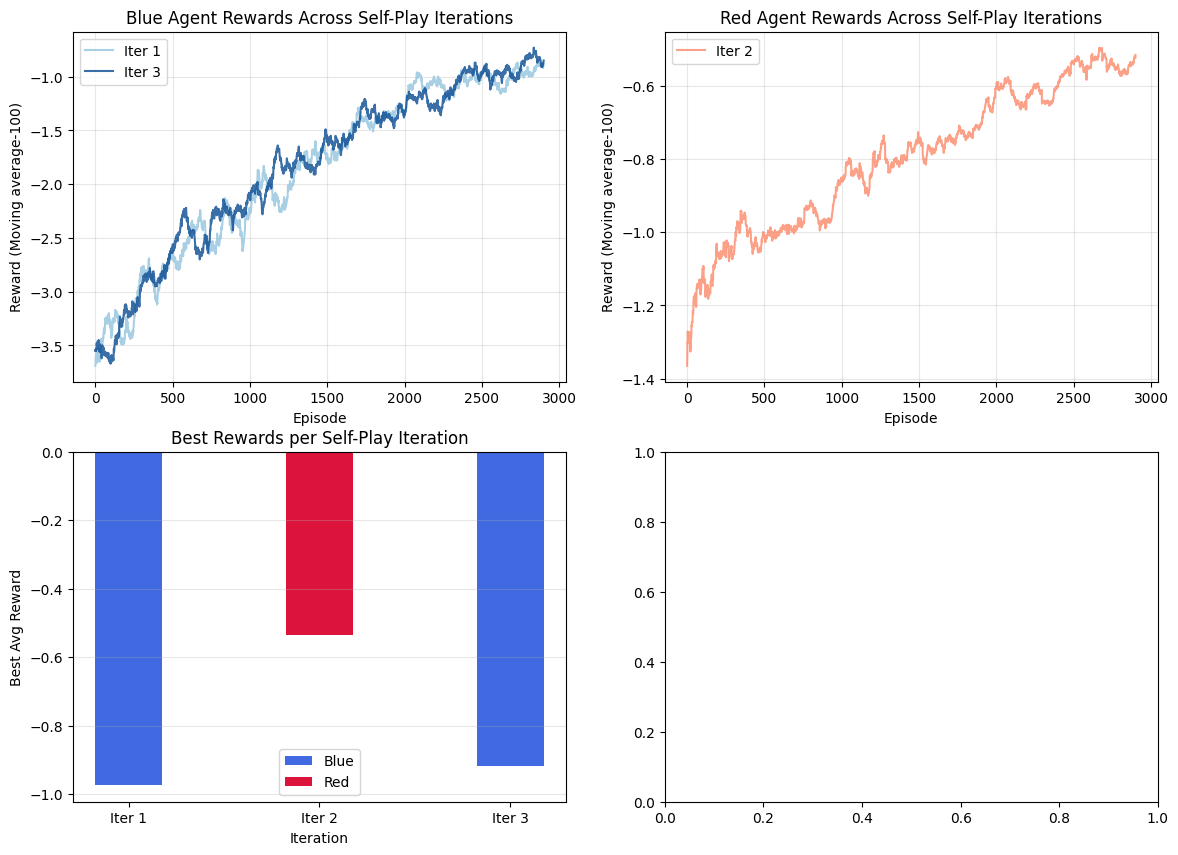

In [ ]:
# VISUALIZATION & ANALYSIS

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
colors_blue = plt.cm.Blues(np.linspace(0.4, 0.9, len(selfplay_history['blue_rewards'])))
for i, rewards in enumerate(selfplay_history['blue_rewards']):
    iter_num = i * 2 + 1
    window = 100
    ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax1.plot(ma, color=colors_blue[i], label=f'Iter {iter_num}', alpha=0.8)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward (Moving average-100)')
ax1.set_title('Blue Agent Rewards Across Self-Play Iterations')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
colors_red = plt.cm.Reds(np.linspace(0.4, 0.9, max(1, len(selfplay_history['red_rewards']))))
for i, rewards in enumerate(selfplay_history['red_rewards']):
    iter_num = i * 2 + 2
    window = 100
    ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax2.plot(ma, color=colors_red[i], label=f'Iter {iter_num}', alpha=0.8)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Reward (Moving average-100)')
ax2.set_title('Red Agent Rewards Across Self-Play Iterations')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
iterations = list(range(1, sp_cfg.num_iterations + 1))
blue_bests = []
red_bests = []
for i in iterations:
    if i % 2 == 1:  # Blue iteration
        idx = (i - 1) // 2
        if idx < len(selfplay_history['blue_best_rewards']):
            blue_bests.append(selfplay_history['blue_best_rewards'][idx])
            red_bests.append(None)
        else:
            blue_bests.append(None)
            red_bests.append(None)
    else:  # Red iteration
        idx = (i - 2) // 2
        if idx < len(selfplay_history['red_best_rewards']):
            red_bests.append(selfplay_history['red_best_rewards'][idx])
            blue_bests.append(None)
        else:
            blue_bests.append(None)
            red_bests.append(None)

# Plot as bars
x = np.arange(len(iterations))
width = 0.35
for i, (b, r) in enumerate(zip(blue_bests, red_bests)):
    if b is not None:
        ax3.bar(i, b, width, color='royalblue', label='Blue' if i == 0 else '')
    if r is not None:
        ax3.bar(i, r, width, color='crimson', label='Red' if i == 1 else '')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Best Avg Reward')
ax3.set_title('Best Rewards per Self-Play Iteration')
ax3.set_xticks(x)
ax3.set_xticklabels([f'Iter {i}' for i in iterations])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')



Contribution Summary- Anjaneya Bhardwaj (50%), Syed Mohammed Faham(50%)